# Swipe Right on Returns: Forecasting Stocks with Consumer Transaction Trends

**Name**: Al Shodiev<br/>


<hr style="height:2pt">

# Objective

> **Main Objective:** Forecast stock returns for $t+1$ given $r(t-1, t)$ data and credit card spending data and create a trading strategy

<a name="contents"></a> <br>

## Notebook Contents

- [**1. Data Loading and Exploration**](#set_up)
    - [Load the Data](#load_data)
    - [Utils](#utils)
    - [Perform Exploratory Data Analysis (EDA)](#eda)
        - [Data Description + Anomalies](#data_description)
        - [Visualizations](#visualizations)
- [**2. Constructing the Spend Time Series**](#spend_time_series)
    - [Aggregate Spend Data and Plot Time Series](#spend_data)
    - [Analyze Relationship with Active Cohorts](#active_cohort_analysis)
- [**3. Seasonality Analysis and Correction**](#seasonality_correction)
    - [Detect Seasonality](#detect_seasonality)
        - [Time-Series Decomposition](#decomposition)
        - [Stationarity Test](#stationarity_test)
        - [Autocorrelation Analysis](#autocorrelation_analysis)
    - [Baseline Modeling - Implement Seasonality Correction](#implement_correction)
- [**4. Improving the Baseline Model with Feature Engineering**](#feature_engineering)
    - [Apply Smoothing Techniques](#smoothing_applied)
    - [Incorporate Lagged Variables](#lagged_var)
    - [Model Training and Evaluation](#train_eval)
    - [Feature Engineering](#additional_features)
    - [Visualizing Feature Importances](#feature_imp)
    - [Final Modeling](#ht)
- [**6. Sector Performance Analysis**](#sector_analysis)
    - [Evaluate Model by Sector](#model_sector_eval)
    - [Interpretation and Sector Inclusion Decision](#inclusion_exclusion)
- [**7. Trading Strategy Development**](#trading_strategy)
    - [Signal Generation Methods](#signal_generation)
    - [Cumulative PnL](#cum_pnl)
- [**9. Additional Data Sources**](#additional_data)
- [**10. Conclusion and Recommendations**](#conclusion)

<a name="set_up"></a>
## Data Loading and Exploration <div id='set_up'>

<a name="import_package"></a>
### Import packages <div id='import_package'>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')
import os
import math
import pickle
import holidays

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm



from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif, f_regression
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.impute import KNNImputer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import jarque_bera, durbin_watson
from scipy.stats import skew, kurtosis, chi2_contingency

# This makes out plots higher resolution, which makes them easier to see while building
plt.rcParams['figure.dpi'] = 100
sns.set_theme(style='darkgrid')
sns.dark_palette("#69d", reverse=True, as_cmap=True)
sns.set_context("paper")

<a name="utils"></a>
### Utils <div id='utils'>

In [2]:
def analyze_dataset(df: pd.DataFrame, dataset_name: str):
    print(f"\nAnalysis for {dataset_name}:")
    
    print("\nBasic Info:")
    df.info()

    print("\nFirst 5 Rows:")
    print(df.head())

    print("\nStatistical Summary:")
    print(df.describe(include='all'))

    print(f"\nShape of the dataset: {df.shape}")

    print("\nData Types of Columns:")
    print(df.dtypes)

    print("\nMissing Values per Column:")
    print(df.isna().sum())

    print("\nUnique Values per Column:")
    for column in df.columns:
        unique_values = df[column].unique()
        print(f"{column}: {len(unique_values)} unique values")

    # Checking for erroneous (non-numeric) values if numeric column exists
    for column in df.select_dtypes(include='object').columns:
        non_numeric = df[column].str.replace('.', '', 1).str.isdigit() == False
        if non_numeric.any():
            print(f"\nNon-numeric values found in column '{column}':")
            print(df[non_numeric][column])

    # Date range, if there is a date column
    date_columns = df.select_dtypes(include=['datetime', 'datetime64']).columns
    if len(date_columns) > 0:
        for date_col in date_columns:
            print(f"\nDate Range in column '{date_col}':")
            print(f"From {df[date_col].min()} to {df[date_col].max()}")
    else:
        print("\nNo date columns found.")
        
def seasonally_adjust_series(series, period=365):
    # Perform seasonal decomposition (additive model)
    decomposition = sm.tsa.seasonal_decompose(series, model='additive', period=period)
    
    # Subtract the seasonal component to get seasonally adjusted data
    seasonally_adjusted = series - decomposition.seasonal
    
    return seasonally_adjusted

def compute_forecast_power(spending_data, df_pivot_returns,stock_metadata_df):
    correlations = []
    for stock in stock_metadata_df.stock:
        
        merged_data = pd.merge(
            spending_data[stock], 
            df_pivot_returns[stock].shift(-1), 
            left_index=True, 
            right_index=True, 
            how='inner'
        )
        
        merged_data = merged_data.rename(columns={merged_data.columns[0] : 'predictor', merged_data.columns[1] : 'target'})
        merged_data = merged_data.dropna()

        if not merged_data.predictor.index.equals(merged_data.target.index):
            raise ValueError("Predictor and response are not aligned by dates.")

        corr = np.corrcoef(merged_data.predictor, merged_data.target)[0,1]  # Correlation between predictor and target
        correlations.append(corr)
        

    forecast_power = np.mean(correlations)
    
    return forecast_power,correlations
        
def check_weekend_and_holiday_df(df):
    df['is_weekend'] = df['date'].dt.weekday >= 5
    us_holidays = holidays.US()
    df['is_holiday'] = df['date'].isin(us_holidays)

    return df['is_holiday'].sum(), df['is_weekend'].sum()

# Prepare a function to create lagged predictors
def create_lagged_features(predictor, n_lags):
    lagged_data = pd.DataFrame({'predictor': predictor})
    for lag in range(1, n_lags + 1):
        lagged_data[f'lag_{lag}'] = lagged_data['predictor'].shift(lag)
    lagged_data.dropna(inplace=True)  # Drop rows with NaN values after lagging
    return lagged_data

# Function to calculate VIF for each feature
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

def check_stationarity(total_spend_series):
    # 1. Perform Augmented Dickey-Fuller (ADF) Test for Stationarity
    result = adfuller(total_spend_series.dropna().values)

    print(f"ADF Statistic for {stock}: {result[0]}")
    print(f"p-value for {stock}: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

    if (result[1] > 0.05):
        print(f"The series for {stock} is likely non-stationary (fail to reject H0).")
    else:
        print(f"The series for {stock} is likely stationary (reject H0).")


def plot_correlation_matrix(df, exclude_date=True, date_column_name='date'):
    """
    Plots the correlation matrix of the given DataFrame, excluding the date column if specified.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    exclude_date (bool): If True, excludes the 'date' column. Default is True.
    date_column_name (str): The name of the date column if it exists. Default is 'date'.
    """
    # Exclude the date column if specified
    if exclude_date and date_column_name in df.columns:
        df = df.drop(columns=[date_column_name])
    
    # Compute the correlation matrix
    X_corr = df.corr().astype(float)
    
    # Standardize the correlation matrix
    X_corr = (X_corr - X_corr.mean()) / X_corr.std()
    corr_matrix = X_corr.corr()
    
    # Plot the correlation matrix
    plt.matshow(corr_matrix, cmap='coolwarm')
    plt.colorbar()
    plt.title('Correlation Matrix', pad=20)
    plt.show()

def plot_results(predictors, targets, stocks_to_plot=1):
    fig, ax = plt.subplots(figsize=(14, 6))
    stocks = predictors.columns[:stocks_to_plot]
    for stock in stocks:
        if stock in targets.columns:
            valid_data = pd.concat([predictors[stock], targets[stock]], axis=1).dropna()
            ax.scatter(valid_data.iloc[:, 0], valid_data.iloc[:, 1], label=stock, alpha = 0.5)

    ax.set_xlabel('Predictor', fontsize = 12)
    ax.set_ylabel('Future Return', fontsize = 12)
    ax.set_title('Predictor vs. Future Return', fontsize = 12)
    ax.legend()
    plt.show()
    
def correlation_sig_test(r, n):
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed p-value
    return t_stat, p_value

def compute_smoothed_forecast_power(spending_data, df_pivot_returns, stock_metadata_df, window_size=2):
    """
    Function to compute the smoothed forecast power (mean correlation) between spending data and future stock returns.
    
    Parameters:
    - spending_data (pd.DataFrame): DataFrame containing seasonally adjusted spending data.
    - df_pivot_returns (pd.DataFrame): DataFrame containing stock returns data.
    - stock_metadata_df (pd.DataFrame): DataFrame containing stock metadata (list of stock names).
    - window_size (int): Window size for smoothing the predictor (spending data).
    
    Returns:
    - forecast_power_smoothed (float): The mean correlation between smoothed predictor and target (future stock returns).
    - correlations_smoothed (list): List of correlations for each stock.
    """
    correlations_smoothed = []  # To store the correlations with the smoothed predictor

    for stock in stock_metadata_df['stock']:
        # Get the predictor (spending data) and the target (future stock return) for the current stock
        predictor = spending_data[stock].dropna()
        target = df_pivot_returns[stock].shift(-1).dropna()  # Future stock return r(t, t+1)

        # Align predictor and target based on their indices (dates)
        predictor_aligned, target_aligned = predictor.align(target, join='inner')

        print(f"Stock: {stock}")
        print("Predictor (after aligning):")
        print(predictor_aligned)
        print("Target (after aligning):")
        print(target_aligned)

        # Apply smoothing to the predictor using a rolling window
        predictor_smoothed = predictor_aligned.rolling(window=window_size, min_periods=1).mean()

        # Ensure the predictor and target are aligned by checking their indices
        if predictor_smoothed.index.equals(target_aligned.index):
            print(f"Indices aligned for stock: {stock}")
        else:
            print(f"Indices NOT aligned for stock: {stock}")
            continue  # Skip this stock if indices are not aligned

        # Calculate the correlation for the current stock if the lengths match
        if len(predictor_smoothed) == len(target_aligned):
            corr = np.corrcoef(predictor_smoothed, target_aligned)[0, 1]  # Correlation between smoothed predictor and target
            correlations_smoothed.append(corr)
        else:
            print(f"Length mismatch for stock: {stock}")
            continue  # Skip this stock if the lengths don't match

    # Calculate the mean correlation (forecast power) after smoothing the predictor
    forecast_power_smoothed = np.nanmean(correlations_smoothed)
    
    print(f'Forecast Power (Smoothed Predictor): {forecast_power_smoothed}')
    return forecast_power_smoothed, correlations_smoothed

def create_lagged_data(spending_data, df_pivot_returns, stock_id, lag_ls=[2, 5, 7], drop_na=True):
    """
    Function to create lagged predictors for a given stock and merge with its returns data.

    Parameters:
    - spending_data (pd.DataFrame): DataFrame containing the spending data for various stocks.
    - df_pivot_returns (pd.DataFrame): DataFrame containing the stock returns data.
    - stock_id (str): The identifier for the specific stock to create lagged predictors.
    - lag_ls (list): List of integers specifying the lag periods.
    - drop_na (bool): Whether to drop rows with NaN values (default is True).

    Returns:
    - data (pd.DataFrame): DataFrame with lagged predictors and merged target returns, shifted by 1.
    """
    #  DataFrame for the selected stock's spending data
    df = pd.DataFrame(spending_data[stock_id])

    # Add lagged predictors to the DataFrame
    for lag in lag_ls:
        df[f'lag_{lag}'] = df[stock_id].shift(lag)
    
    # Merge the lagged spending data with the stock returns data
    data = pd.merge(df, df_pivot_returns[stock_id], left_index=True, right_index=True, how='left')
    
    # Rename columns for clarity
    data = data.rename(columns={stock_id + '_x': stock_id, stock_id + '_y': 'target'})
    
    # Shift the target column by -1 to represent future returns
    data['target'] = data['target'].shift(-1)
    
    # Step 6: Optionally drop NaN values created by lagging and shifting
    if drop_na:
        data.dropna(inplace=True)

    return data



def process_all_stocks(spending_data, df_pivot_returns, stock_metadata_df, lag_ls=[2, 5, 7], drop_na=True):
    """
    Function to process all stocks listed in the stock_metadata_df and apply the create_lagged_data function to each.
    
    Parameters:
    - spending_data (pd.DataFrame): DataFrame containing the spending data for various stocks.
    - df_pivot_returns (pd.DataFrame): DataFrame containing the stock returns data.
    - stock_metadata_df (pd.DataFrame): DataFrame containing metadata for all stocks.
    - lag_ls (list): List of integers specifying the lag periods.
    - drop_na (bool): Whether to drop rows with NaN values (default is True).
    
    Returns:
    - stocks_lagged_data (dict): Dictionary where each stock_id is the key and the lagged DataFrame is the value.
    """
    stocks_lagged_data = {}  # Dictionary to store the lagged DataFrames for each stock
    
    # Loop through each stock in stock_metadata_df
    for stock in stock_metadata_df['stock']:
        # Create lagged data for each stock
        lagged_data = create_lagged_data(spending_data, df_pivot_returns, stock_id=stock, lag_ls=lag_ls, drop_na=drop_na)
        
        # Store the resulting DataFrame in the dictionary
        stocks_lagged_data[stock] = lagged_data
    
    return stocks_lagged_data

def run_time_series_split_regression(stocks_lagged_data, gics_sectors, scale_target=False, train_size=0.8):
    results = {}
    sector_results = {}

    if scale_target:
        scaler = StandardScaler()

    for stock_id, data in stocks_lagged_data.items():
        # Define predictor variables and target variable
        X = data.drop(columns=['target'])
        y = data['target']
        
        if scale_target:
            y = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()  # Scale the target
        
        # Time series train-test split based on provided train_size
        train_idx = int(len(X) * train_size)
        X_train, X_test = X[:train_idx], X[train_idx:]
        y_train, y_test = y[:train_idx], y[train_idx:]

        # Fit Linear Regression model using sklearn
        linreg_model = LinearRegression().fit(X_train, y_train)

        # Predictions
        y_pred = linreg_model.predict(X_test)
        
        # Metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Calculate residuals
        residuals = y_test - y_pred

        # Durbin-Watson and Jarque-Bera tests for residuals
        durbin_watson_stat = durbin_watson(residuals)
        jb_test = jarque_bera(residuals)[1]  # Jarque-Bera test p-value

        # Multicollinearity check with VIF
        X_train_with_const = sm.add_constant(X_train)  # Add constant for VIF calculation
        vif_data = pd.DataFrame()
        vif_data["VIF"] = [variance_inflation_factor(X_train_with_const.values, i) for i in range(X_train_with_const.shape[1])]
        vif_data["Predictor"] = X_train_with_const.columns

        # Store stock-level results
        results[stock_id] = {
            "model": linreg_model,
            "rmse": rmse,
            "mae": mae,
            "r2": r2,
            "durbin_watson_stat": durbin_watson_stat,
            "jarque_bera_pvalue": jb_test,
            "vif": vif_data,
            "coefficients": linreg_model.coef_,
            "intercept": linreg_model.intercept_,
        }

        # Get the GICS sector for this stock
        gics_sector = gics_sectors[stock_id]
        
        # Initialize the sector entry if not already present
        if gics_sector not in sector_results:
            sector_results[gics_sector] = {
                'rmse': [],
                'r2': [],
                'mae': []
            }
        
        # Append the results to the appropriate sector
        sector_results[gics_sector]['rmse'].append(rmse)
        sector_results[gics_sector]['r2'].append(r2)
        sector_results[gics_sector]['mae'].append(mae)

    # Compute average metrics for each sector
    for sector in sector_results:
        sector_results[sector]['avg_rmse'] = np.mean(sector_results[sector]['rmse'])
        sector_results[sector]['avg_r2'] = np.mean(sector_results[sector]['r2'])
        sector_results[sector]['avg_mae'] = np.mean(sector_results[sector]['mae'])

    return results, sector_results

def create_result_table(result_data, decimal_places=6):
    """
    Create a DataFrame with model evaluation metrics for a stock and round values.
    
    Parameters:
    - result_data (dict): Dictionary containing model evaluation metrics.
    - decimal_places (int): Number of decimal places to round the values to (default is 6).
    
    Returns:
    - DataFrame: A DataFrame showing the metrics and their values, rounded to specified decimal places.
    """
    
    # Format VIF DataFrame as a string for display
    #vif_str = result_data['vif'].to_string(index=False)
    
    # Format the coefficients array to a list with rounded values
    coefficients_rounded = [round(coef, decimal_places) for coef in result_data['coefficients']]
    
    result_dict = {
        'Metric': ['Model', 'RMSE', 'R-squared', 'MAE', 'Durbin-Watson', 'Jarque-Bera p-value', 'Coefficients', 'Intercept'],
        'Value': [
            str(result_data['model']),  # Model as string
            round(result_data['rmse'], decimal_places), 
            round(result_data['r2'], decimal_places), 
            round(result_data['mae'], decimal_places), 
            round(result_data['durbin_watson_stat'], decimal_places), 
            round(result_data['jarque_bera_pvalue'], decimal_places), 
            #vif_str,  # VIF DataFrame formatted as string
            coefficients_rounded,  # Rounded coefficients
            round(result_data['intercept'], decimal_places)
        ]
    }
    
    result_df = pd.DataFrame(result_dict)
    
    return result_df

def plot_jarque_bera_pvalues(results):
    jb_pvalues = [results[stock_id]['jarque_bera_pvalue'] for stock_id in results]
    stocks = list(results.keys())
    
    plt.figure(figsize=(14, 6))
    plt.bar(stocks, jb_pvalues, color='skyblue')
    plt.xticks(rotation=90)
    plt.axhline(y=0.05, color='r', linestyle='--', label='0.05 threshold (significance level)')
    plt.title('Jarque-Bera Test P-Values Across All Stocks')
    plt.xlabel('Stock ID')
    plt.ylabel('P-value')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to plot Durbin-Watson statistics across all stocks
def plot_durbin_watson_stats(results):
    dw_stats = [results[stock_id]['durbin_watson_stat'] for stock_id in results]
    stocks = list(results.keys())
    
    plt.figure(figsize=(14, 6))
    plt.bar(stocks, dw_stats, color='lightgreen')
    plt.xticks(rotation=90)
    plt.axhline(y=2, color='r', linestyle='--', label='Ideal value (2)')
    plt.title('Durbin-Watson Statistics Across All Stocks')
    plt.xlabel('Stock ID')
    plt.ylabel('Durbin-Watson Statistic')
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_feature_importances(rf_model, lasso_model, feature_names, stock_id):
    """
    Plot the feature importances for both Random Forest and Lasso models.
    
    Parameters:
    rf_model: Fitted RandomForestRegressor model
    lasso_model: Fitted Lasso model
    feature_names: List of feature names (columns of X)
    stock_id: Stock ID for which the plot is created
    """
    
   
    rf_importances = rf_model.feature_importances_
    lasso_importances = np.abs(lasso_model.coef_)

    # Check if the length of feature_names matches the number of features in models
    if len(feature_names) != len(rf_importances):
        raise ValueError(f"Mismatch: {len(feature_names)} feature names provided, but model used {len(rf_importances)} features.")

    
    fig, axs = plt.subplots(1, 2, figsize=(18, 4))
    
    axs[0].barh(feature_names, rf_importances)
    axs[0].set_title(f"Random Forest Feature Importances for Stock {stock_id}")
    axs[0].set_xlabel('Importance')
    
    axs[1].barh(feature_names, lasso_importances)
    axs[1].set_title(f"Lasso Feature Coefficients for Stock {stock_id}")
    axs[1].set_xlabel('Coefficient Magnitude')
    
    plt.tight_layout()
    plt.show()


def train_models(stock_dataframes, df_pivot_returns, features=None):
    # store results for each stock
    results = {}

    # Loop through each stock's data in the dictionary
    for stock_id, stock_df in stock_dataframes.items():
        # Merge the predictors (stock_df) with the target (returns for that stock in df_pivot_returns)
        data = pd.merge(stock_df, df_pivot_returns[stock_id], left_index=True, right_index=True, how='left')
        
        # Rename the return column as 'target' for clarity
        data.rename(columns={stock_id: 'target'}, inplace=True)
        
        # Shift the target by -1 to use (t-1, t) to predict (t, t+1)
        data['target'] = data['target'].shift(-1)
        
        # Drop any rows with NaN values (due to shifting)
        data.dropna(inplace=True)
        
        # Filter the features if a list is provided
        if features:
            X = data[features]
        else:
            X = data.drop(columns=['target'])
        
        # Separate the target (y)
        y = data['target'].values

        # Train-test split (make sure to shuffle=False to respect time series ordering)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Initialize models
        rf_model = RandomForestRegressor(
            n_estimators=10,  # Number of trees in the forest
            max_depth=2,      # Maximum depth of each tree
            random_state=42,   # Ensures reproducibility
            max_features='sqrt'  # Number of features to consider when looking for the best split
        )

        lasso_model = Lasso(
            alpha=0.001,  # Regularization strength (smaller value means less regularization)
        )
        
        # Fit Random Forest model
        rf_model.fit(X_train, y_train)
        rf_predictions = rf_model.predict(X_test)
        
        # Fit Lasso model
        lasso_model.fit(X_train, y_train)
        lasso_predictions = lasso_model.predict(X_test)
        
        # Calculate metrics for Random Forest
        rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
        rf_r2 = r2_score(y_test, rf_predictions)
        rf_mae = mean_absolute_error(y_test, rf_predictions)
        
        # Calculate metrics for Lasso
        lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_predictions))
        lasso_r2 = r2_score(y_test, lasso_predictions)
        lasso_mae = mean_absolute_error(y_test, lasso_predictions)
        
        # Store the results in the dictionary for this stock
        results[stock_id] = {
            'Random Forest': {
                'model' : rf_model,
                'RMSE': rf_rmse,
                'R²': rf_r2,
                'MAE': rf_mae
            },
            'Lasso': {
                'model' : lasso_model,
                'RMSE': lasso_rmse,
                'R²': lasso_r2,
                'MAE': lasso_mae
            }
        }
    
    return results

def plot_sector_metrics(sector_results):
    sector_df = pd.DataFrame(sector_results).T  # Transpose to get sectors as rows
    sector_df = sector_df[['avg_rmse', 'avg_mae']]  # Keep relevant columns
    
    # Sorting the sectors based on each metric in descending order
    rmse_sorted = sector_df.sort_values(by='avg_rmse', ascending=True)
    mae_sorted = sector_df.sort_values(by='avg_mae', ascending=True)

    # Creating subplots with 3 axes
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # RMSE Plot - Ordered from highest to lowest
    sns.barplot(x=rmse_sorted.index, y=rmse_sorted['avg_rmse'], ax=axs[0], palette="Blues_d", order=rmse_sorted.index)
    axs[0].set_title('Average RMSE by GICS Sector')
    axs[0].set_xlabel('GICS Sector')
    axs[0].set_ylabel('Average RMSE')
    axs[0].tick_params(axis='x', rotation=45)

    # MAE Plot - Ordered from highest to lowest
    sns.barplot(x=mae_sorted.index, y=mae_sorted['avg_mae'], ax=axs[1], palette="Blues_d", order=mae_sorted.index)
    axs[1].set_title('Average MAE by GICS Sector)')
    axs[1].set_xlabel('GICS Sector')
    axs[1].set_ylabel('Average MAE')
    axs[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def calculate_z_scores(df, window=252):
    """
    Calculate the rolling z-scores of seasonally adjusted spend data for overbought/oversold detection.
    :param df: DataFrame containing the seasonally adjusted spend data.
    :param window: The window length to calculate historical mean and std deviation (default: 252 trading days = 1 year).
    :return: DataFrame of z-scores.
    """
    rolling_mean = df.rolling(window=window).mean()
    rolling_std = df.rolling(window=window).std()
    
    z_scores = (df - rolling_mean) / rolling_std
    return z_scores

def identify_overbought_oversold(z_scores, upper_threshold=2, lower_threshold=-1.5):
    """
    Identify overbought and oversold conditions based on z-scores.
    :param z_scores: DataFrame containing z-scores.
    :param upper_threshold: Z-score above which a stock is considered overbought.
    :param lower_threshold: Z-score below which a stock is considered oversold.
    :return: DataFrame with signals: 1 for oversold (buy), -1 for overbought (sell), 0 for neutral.
    """
    signals = pd.DataFrame(0, index=z_scores.index, columns=z_scores.columns)
    
    signals[z_scores > upper_threshold] = -1  # Overbought: Sell signal
    signals[z_scores < lower_threshold] = 1   # Oversold: Buy signal
    
    return signals
def backtest_strategy(signals, returns_df, initial_investment=1000000):
    """
    Backtest a strategy based on overbought/oversold signals, starting with an initial amount of money.
    :param signals: DataFrame with buy/sell signals (1 for buy, -1 for sell, 0 for neutral).
    :param returns_df: DataFrame with stock/sector returns.
    :param initial_investment: Starting amount of money for the backtest.
    :return: Cumulative portfolio value over time.
    """
    # Shift signals by 1 to account for next-day action
    strategy_returns = signals.shift(1) * returns_df
    
    # Calculate the cumulative return of the strategy
    cumulative_returns = (1 + strategy_returns).cumprod()
    
    # Multiply by the initial investment to get portfolio value over time
    portfolio_value = cumulative_returns * initial_investment
    
    return portfolio_value

def calculate_performance_metrics(cumulative_returns):
    """
    Calculate various performance metrics for a strategy based on cumulative returns.
    :param cumulative_returns: Series of cumulative returns.
    :return: Dictionary of performance metrics.
    """
    # Calculate daily returns from cumulative returns
    daily_returns = cumulative_returns.pct_change().dropna()
    
    # Calculate Sharpe ratio (annualized, assuming 252 trading days in a year)
    sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std()
    
    # Calculate maximum drawdown
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Calculate hit ratio (percentage of positive daily returns)
    hit_ratio = (daily_returns > 0).sum() / daily_returns.count()
    
    # Calculate annualized return (CAGR)
    total_return = cumulative_returns.iloc[-1] / cumulative_returns.iloc[0] - 1
    n_years = len(cumulative_returns) / 252
    
    # Calculate annualized volatility (std dev of daily returns annualized)
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # Return all metrics as a dictionary
    performance_metrics = {
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Hit Ratio': hit_ratio,
        'Annualized Volatility': annualized_volatility
    }
    
    return performance_metrics

<a name="load_data"></a>
### Load the Data <div id='load_data'>

In [4]:
card_spending_df = pd.read_csv('../homework data/card_spending_dataset.csv')
stock_metadata_df = pd.read_csv('../homework data/stock_metadata.csv')
stock_returns_df = pd.read_csv('../homework data/stock_returns.csv')

<a name="eda"></a>
### Perform Exploratory Data Analysis (EDA) <div id='eda'>

<a name="data_description"></a>
### Data Description + Anomalies <div id='data_description'>

The dataset consists of credit card transactions, credit card user cohorts, stocks, stock returns and different industries to which companies belong to. 
The data ranges from January 1, 2015 to January, 1 2023 and reports returns across 100 unique stocks in 6 different GICS sectors while the credit card transaction data spans 10 different groups of users. 

Features

*   There are numerical features - Spend, Stock return (float64)
*   There are categorical features of nominal type. For example, there is a categorical feature “cohort” (object) which represents group of credit card users likely based on demographics, spending behaviour etc., "stock"  (object) which indicates the publicly traded companies and "GICS Sector" (int64) which stand for industries the publicly traded companies belong to.

Response variable 

> **"return"** in stock_returns_df is  a continuous variable that represents the percentage change in the stock price over the previous day (backward return).

In [6]:
analyze_dataset(card_spending_df, "Card Spending Dataset")
analyze_dataset(stock_metadata_df, "Stock Metadata Dataset")
analyze_dataset(stock_returns_df, "Stock Returns Dataset")


Analysis for Card Spending Dataset:

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498000 entries, 0 to 1497999
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   date    1498000 non-null  object
 1   cohort  1498000 non-null  object
 2   stock   1498000 non-null  object
 3   spend   1483180 non-null  object
dtypes: object(4)
memory usage: 45.7+ MB

First 5 Rows:
         date cohort stock               spend
0  2015-01-01     C0    S0  30978.650325943345
1  2015-01-01     C0    S1   220187.8215461831
2  2015-01-01     C0   S10  -472572.3319345556
3  2015-01-01     C0   S11  25674.031067677144
4  2015-01-01     C0   S12   25593.69445553843

Statistical Summary:
              date   cohort    stock    spend
count      1498000  1498000  1498000  1483180
unique        2923       10      100  1388760
top     2022-01-02       C3       S0    a928a
freq          1000   219200    14980     1546

Shape of the datase

Based on the above:<br>
* Card Spending Dataset Summary: 
    * There are Negative values which are object type and strings 'a298a' which are non-numerical and occur 1546 times - the total is 16538 rows
    * There are 14820 missing values. **We will check for missingness type to determine the best to deal with them**
    * The data is significantly right skewed, with a median spend of around 54,000, but the mean is over 12.5 million due to extreme outliers. The maximum value is exceedingly high at around 115.8 billion.
    * Dataset will need to be reorganized into a pivot table so that we can do cross-sectional analysis on spending patters of various cohorts and aggregate spending. Note: Spending data is segmented by cohorts, which may not be present every day for every stock.
 
* Stock Metadata Dataset Sumary: <br>
    * No issues - the mapping between stocks and sectors would have to be integrated into Card Spending data for additional features which **we will One-Hot Encode (OHE) later**<br>

* Stock Returns Dataset Summary: <br>
    * No issues - the returns data will serve as my target variable for forecasting. **I will transform this later to make it suitable for forecasting** <br>

To-Do:
1. Drop Negative values, strings in Card Spending Data
2. Check Missingness type of missing values in Card Spending Data to determine the best way to deal with them
3. Create a binary column to indicate missing spend - assume negative values and strings are 0 spend
3. Apply a transformation in the spend column in Card Spending Data to reduce skewness and effects of outliers for better visualiation and modeling purposes
4. Transform the Card Spending Data into a pivot table
5. Conver the 'date' column to datetime format
6. Create a dictionary of Stocks to GICS Sector

In [7]:
card_spending_df['spend'] = pd.to_numeric(card_spending_df['spend'], errors='coerce')
card_spending_df['missing_spend'] = card_spending_df['spend'].isna() | (card_spending_df['spend'] < 0)
card_spending_df['missing_spend'] = card_spending_df['missing_spend'].astype(int)
card_spending_df = card_spending_df[card_spending_df['spend'].ge(0) | card_spending_df['spend'].isna()]

# Chi-square test for missingness
contingency_table = pd.crosstab(card_spending_df['missing_spend'], card_spending_df['cohort'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}, p-value: {p}")

if p < 0.05:
    print("The data is likely MAR (Missing At Random) with respect to the cohort")
else:
    print("The data is likely MCAR (Missing Completely At Random)")

Chi-square statistic: 5.657118636760699, p-value: 0.7736839852337629
The data is likely MCAR (Missing Completely At Random)


Since p > 0.05, the null hypothesis is rejectee and data is MCAR. Hence, we can drop

In [8]:
card_spending_df = card_spending_df.dropna()
card_spending_df.shape, card_spending_df.isna().sum()

((1466642, 5),
 date             0
 cohort           0
 stock            0
 spend            0
 missing_spend    0
 dtype: int64)

In [9]:
card_spending_df['date'] = pd.to_datetime(card_spending_df['date'])
stock_returns_df['date'] = pd.to_datetime(stock_returns_df['date'])

In [10]:
credit_card_spending_df = pd.merge(card_spending_df, stock_metadata_df[['stock', 'GICS sector']], on='stock', how='left')
print(credit_card_spending_df.head())

        date cohort stock          spend  missing_spend  GICS sector
0 2015-01-01     C0    S0   30978.650326              0           30
1 2015-01-01     C0    S1  220187.821546              0           35
2 2015-01-01     C0   S11   25674.031068              0           30
3 2015-01-01     C0   S12   25593.694456              0           30
4 2015-01-01     C0   S13  106138.042637              0           50


In [11]:
duplicates = credit_card_spending_df.duplicated()
print(credit_card_spending_df[duplicates])

Empty DataFrame
Columns: [date, cohort, stock, spend, missing_spend, GICS sector]
Index: []


In [12]:
gics_sectors = stock_metadata_df.set_index('stock')['GICS sector'].to_dict()
gics_sectors

{'S0': 30,
 'S1': 35,
 'S2': 30,
 'S3': 30,
 'S4': 25,
 'S5': 30,
 'S6': 25,
 'S7': 45,
 'S8': 50,
 'S9': 25,
 'S10': 40,
 'S11': 30,
 'S12': 30,
 'S13': 50,
 'S14': 20,
 'S15': 20,
 'S16': 10,
 'S17': 45,
 'S18': 40,
 'S19': 45,
 'S20': 50,
 'S21': 40,
 'S22': 25,
 'S23': 40,
 'S24': 25,
 'S25': 30,
 'S26': 25,
 'S27': 50,
 'S28': 30,
 'S29': 25,
 'S30': 25,
 'S31': 40,
 'S32': 25,
 'S33': 30,
 'S34': 10,
 'S35': 30,
 'S36': 30,
 'S37': 30,
 'S38': 50,
 'S39': 30,
 'S40': 25,
 'S41': 25,
 'S42': 30,
 'S43': 20,
 'S44': 30,
 'S45': 30,
 'S46': 25,
 'S47': 25,
 'S48': 25,
 'S49': 25,
 'S50': 30,
 'S51': 25,
 'S52': 50,
 'S53': 25,
 'S54': 25,
 'S55': 25,
 'S56': 30,
 'S57': 25,
 'S58': 25,
 'S59': 25,
 'S60': 25,
 'S61': 25,
 'S62': 30,
 'S63': 25,
 'S64': 25,
 'S65': 25,
 'S66': 45,
 'S67': 20,
 'S68': 45,
 'S69': 20,
 'S70': 50,
 'S71': 25,
 'S72': 50,
 'S73': 30,
 'S74': 35,
 'S75': 10,
 'S76': 25,
 'S77': 25,
 'S78': 25,
 'S79': 25,
 'S80': 25,
 'S81': 25,
 'S82': 20,
 'S83': 30,
 '

<a name="visualizations"></a>
### Visualizations <div id='visualizations'>

Questions I wanted to explore: 

1. How does the spending distribution vary across different cohorts and sectors, and are there any distinct patterns or outliers observed in specific sectors?

2. What are the key trends and seasonal variations in spending over months, quarters, or years? Are there any noticeable cyclical patterns or anomalies?

3. What relationships exist between the spending behaviors of different cohorts? Which cohorts have the strongest correlations, and how might these correlations inform business strategies?

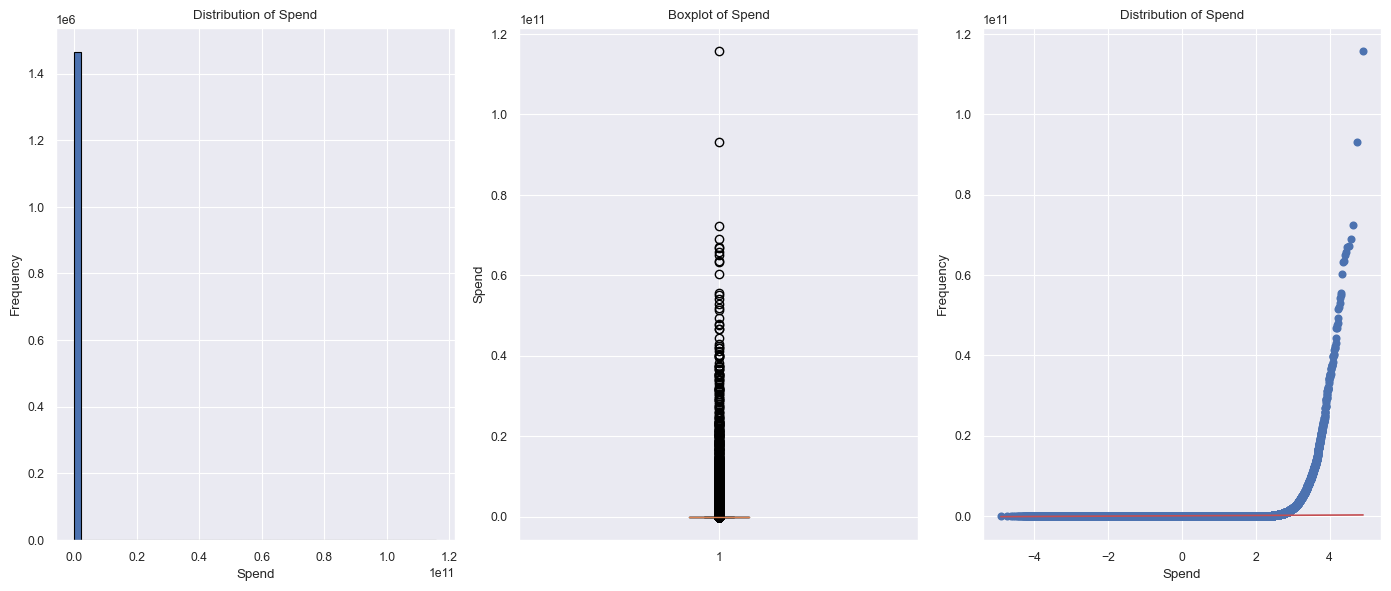

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

ax[0].hist(credit_card_spending_df['spend'], bins=50, edgecolor='black')
ax[0].set_title('Distribution of Spend')
ax[0].set_xlabel('Spend')
ax[0].set_ylabel('Frequency')

ax[1].boxplot(credit_card_spending_df['spend'])
ax[1].set_title('Boxplot of Spend')
ax[1].set_ylabel('Spend')


stats.probplot(credit_card_spending_df['spend'], plot=plt)
ax[2].set_title('Distribution of Spend')
ax[2].set_xlabel('Spend')
ax[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [14]:
#skewness and kurtosis
print("Skewness: %f" % credit_card_spending_df['spend'].skew())
print("Kurtosis: %f" % credit_card_spending_df['spend'].kurt())

Skewness: 93.562187
Kurtosis: 13493.522316


Skewness and Kurtosis are extremely high, suggesting a very right- skewed data with a very sharp peak compared to the normal distribution, indicating a heavy-tailed distribution. As (linear) models love normally distributed data, we need to transform this variable and make it more normally distributed.

In [15]:
from scipy.stats import boxcox
# Check if there are zero or negative values and adjust
if (credit_card_spending_df['spend'] <= 0).any():
    offset = abs(credit_card_spending_df['spend'].min()) + 1
    credit_card_spending_df['adjusted_spend'] = credit_card_spending_df['spend'] + offset
else:
    credit_card_spending_df['adjusted_spend'] = credit_card_spending_df['spend']

# Apply Box-Cox transformation
credit_card_spending_df['transformed_spend'], fitted_lambda = boxcox(credit_card_spending_df['adjusted_spend'])

# Check transformed skewness and kurtosis
transformed_skewness = credit_card_spending_df['transformed_spend'].skew()
transformed_kurtosis = credit_card_spending_df['transformed_spend'].kurt()

print("Transformed Skewness:", transformed_skewness)
print("Transformed Kurtosis:", transformed_kurtosis)
print("Lambda used for Box-Cox Transformation:", fitted_lambda)

Transformed Skewness: -0.045305348428676666
Transformed Kurtosis: 1.2348822437569478
Lambda used for Box-Cox Transformation: -0.04751340345755505


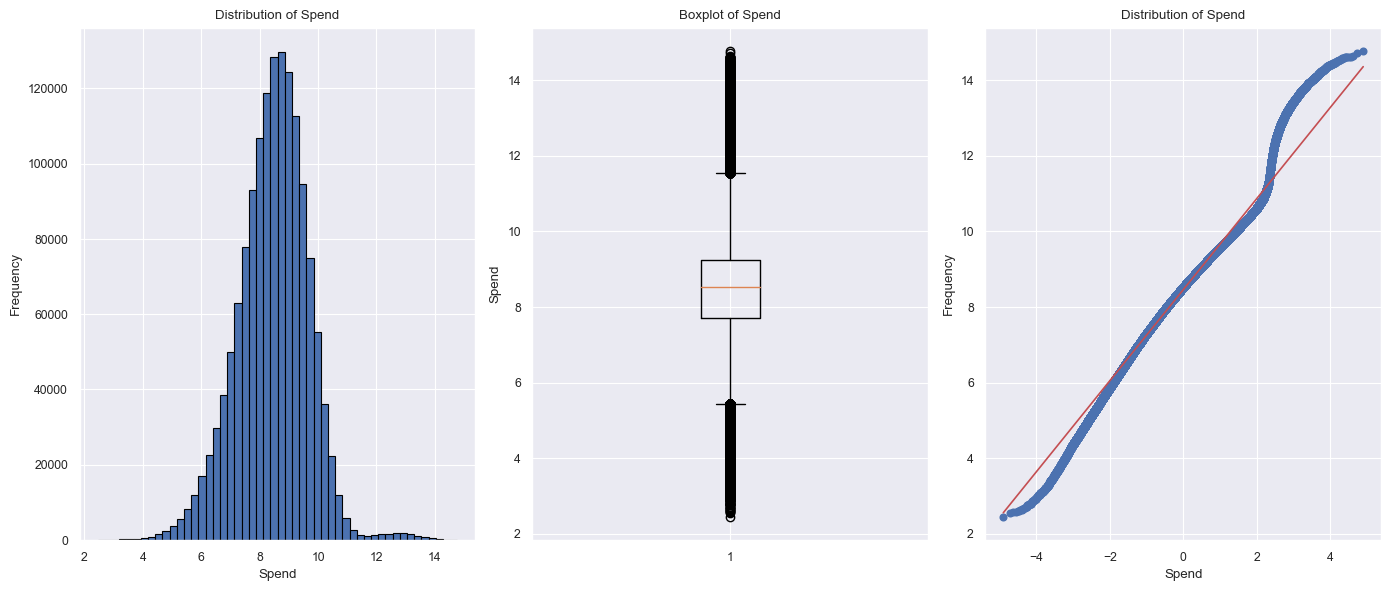

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

ax[0].hist(credit_card_spending_df['transformed_spend'], bins=50, edgecolor='black')
ax[0].set_title('Distribution of Spend')
ax[0].set_xlabel('Spend')
ax[0].set_ylabel('Frequency')

ax[1].boxplot(credit_card_spending_df['transformed_spend'])
ax[1].set_title('Boxplot of Spend')
ax[1].set_ylabel('Spend')


stats.probplot(credit_card_spending_df['transformed_spend'], plot=plt)
ax[2].set_title('Distribution of Spend')
ax[2].set_xlabel('Spend')
ax[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Since our subsequent analyses strongly depend on the normality of the data (Fitting a Linear Model), Box-Cox Transformation generally shows better alignment with the assumptions of normality. The data appears more symmetric, and the Q-Q plot indicates a better fit to the normal distribution. This transformation has effectively addressed both the skewness and the kurtosis, making it more suitable for our analysis

#### 1. Spending Patterns of Different Cohorts

For our plots, I will use the transformed_spend for consistency because using raw spend data would not show all the patterns and the plot would be distorted due to outliers

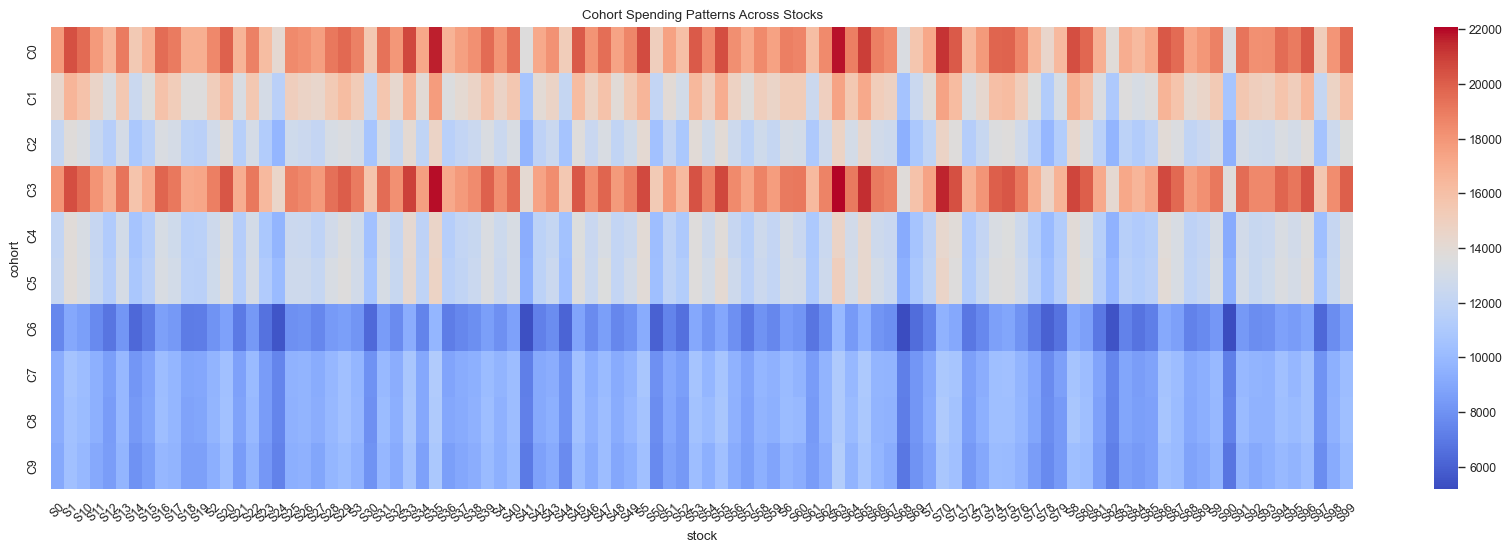

In [17]:
cohort_spending = credit_card_spending_df.groupby(['cohort', 'stock'])['transformed_spend'].sum().unstack()

plt.figure(figsize=(21,6))
sns.heatmap(cohort_spending, cmap='coolwarm')
plt.title('Cohort Spending Patterns Across Stocks')
plt.xticks(rotation = 45)
plt.show()

#### 2. Distribution of Cohorts and Sectors in the Data

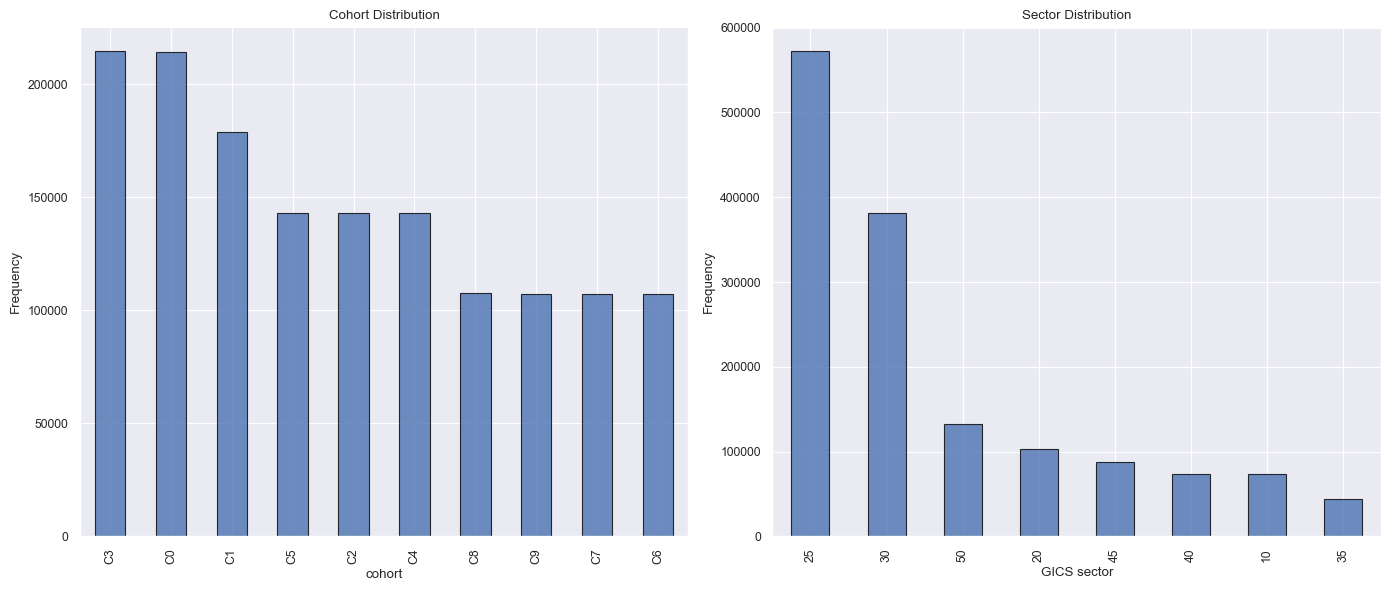

In [18]:
cohort_dist = credit_card_spending_df['cohort'].value_counts()
sector_dist = credit_card_spending_df['GICS sector'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

cohort_dist.plot(kind='bar', ax=ax[0], edgecolor='black', alpha = 0.8)
ax[0].set_title('Cohort Distribution')
ax[0].set_ylabel('Frequency')

sector_dist.plot(kind='bar', ax=ax[1], edgecolor='black', alpha = 0.8)
ax[1].set_title('Sector Distribution')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In Cohort Distribution, we observe that Cohorts C3, C0 and C1 are the most active/represented cohorts in the dataset. On the other hand, Cohorts C8, C9, C6 and C6 are less active/represetend cohorts in the dataset. 

In Sector Distribution, we observe that Sector 25 and 30 are the most active/represented sectors in the dataset compared to other sectors. The least active/represented sector is 35. Stocks tied to sectors with higher transaction occurrences (like sectors 25 and 30) might experience more consistent or predictable trends, as these sectors represent areas with high consumer engagement. Sectors with fewer occurrences (such as 10, 35, 40) might offer opportunities for spotting early trends or identifying stocks with more potential for growth. 


**Hypothesis: I hypothesize that sectors and cohorts that demonstrate a high volume of transactions are likely to exhibit stronger correlations with stock price movements.**

When building our model, we could also explore: 
2. consider giving more weight to transactions from the highly active cohorts and sectors. 

#### 3. Trends and Seasonality in Spending (By Month, Quarter, Year)

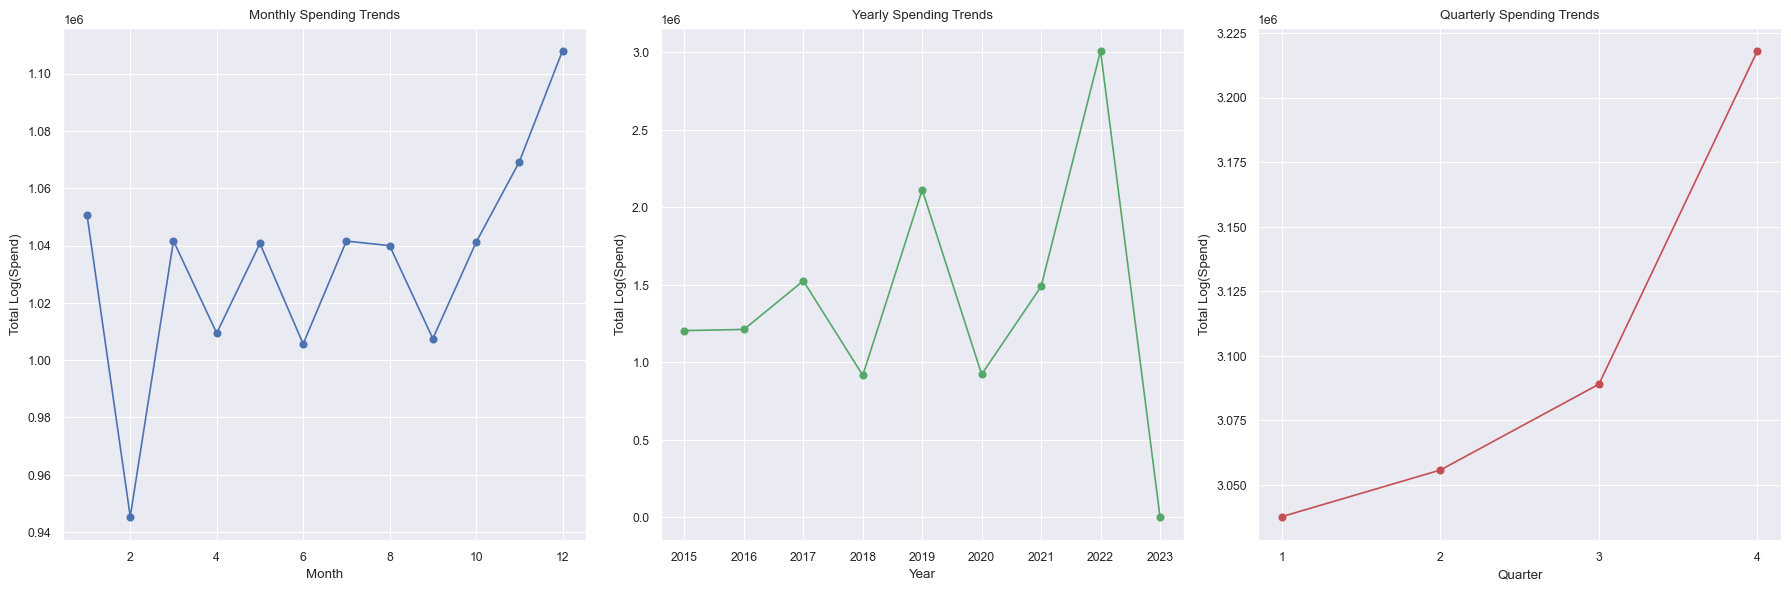

In [19]:
credit_card_spending_df['month'] = credit_card_spending_df['date'].dt.month
credit_card_spending_df['quarter'] = credit_card_spending_df['date'].dt.quarter
credit_card_spending_df['year'] = credit_card_spending_df['date'].dt.year

monthly_trends = credit_card_spending_df.groupby(['month'])['transformed_spend'].sum()
yearly_trends = credit_card_spending_df.groupby(['year'])['transformed_spend'].sum()
quarterly_trends = credit_card_spending_df.groupby(['quarter'])['transformed_spend'].sum()

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Monthly spending trends
ax[0].plot(monthly_trends.index, monthly_trends.values, marker='o', linestyle='-', color='b')
ax[0].set_title('Monthly Spending Trends')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Total Log(Spend)')

# Yearly spending trends
ax[1].plot(yearly_trends.index, yearly_trends.values, marker='o', linestyle='-', color='g')
ax[1].set_title('Yearly Spending Trends')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Total Log(Spend)')

# Quarterly spending trends
ax[2].plot(quarterly_trends.index, quarterly_trends.values, marker='o', linestyle='-', color='r')
ax[2].set_title('Quarterly Spending Trends')
ax[2].set_xticks([1,2,3,4])
ax[2].set_xlabel('Quarter')
ax[2].set_ylabel('Total Log(Spend)')

plt.tight_layout()
plt.show()

Key Observations:
- There are seasonal patterns, noted by The monthly and quarterly trends
- Both the monthly and quarterly show year-end increases in spending, suggesting seasonal factors like holiday shopping,vacationing etc.

Some Monthly Trends
- The months of March, May, July, and October show peaks or increases, while February and September show dips.
- The spending shows a sharp increase toward the end of the year, peaking in December. This could be indicative of seasonal spending patterns, such as holiday season spending, which typically occurs in Q4 (e.g., December)

Some Yearly Trends
- There is a high volatility in spending between years. We can observe a relatively stable trend from 2015-2017, sharp decrease in 2018 due to the Trump administration’s tariffs on imported aluminum, steel, and other goods which had introduced a large amount of uncertainty into the global economy, The Fed's interest rate hikes etc. There is a drop in 2020, followed by a sharp increase which coincides with the pandemic and change in spending behaviours. There is another sharp increase in 2021- 2022 which is likely due to increased government stimulus and other online spending trends as the world shifted more towards e-commerce but a drop in 2023 due to partial data

Some Quarterly Trends
- Q4 (Oct-Dec)  experiences the sharpest increase likely due to holiday shoppping and year-end activities


#### 4. Distribution of Total Log Spend by Sector and Cohort

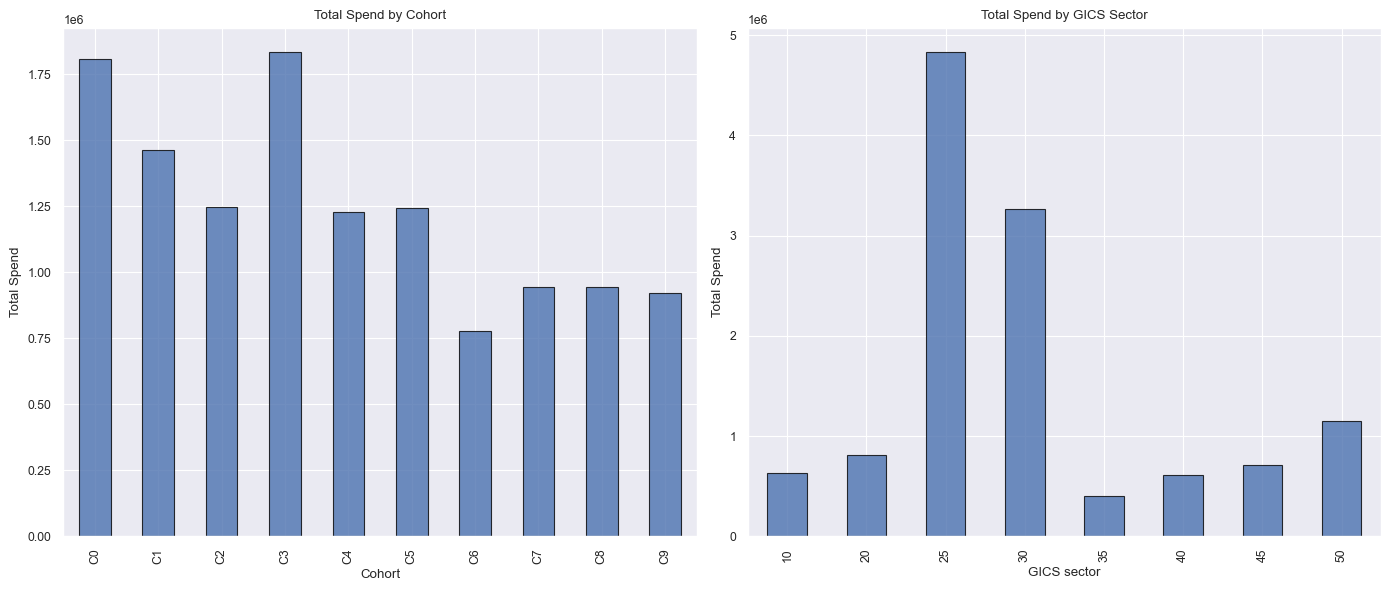

In [20]:
cohort_spend = credit_card_spending_df.groupby('cohort')['transformed_spend'].sum()
sector_spend = credit_card_spending_df.groupby('GICS sector')['transformed_spend'].sum()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

cohort_spend.plot(kind='bar', ax=ax[0], edgecolor='black', alpha = 0.8)
ax[0].set_title('Total Spend by Cohort')
ax[0].set_xlabel('Cohort')
ax[0].set_ylabel('Total Spend')

sector_spend.plot(kind='bar', ax=ax[1], edgecolor='black', alpha = 0.8)
ax[1].set_title('Total Spend by GICS Sector')
ax[1].set_ylabel('Total Spend')

plt.tight_layout()
plt.show()

This confirms the high activity of Sectore 25 and 30 and the low activity of sector 35 as well as the activity of Cohorts C3, C0 and C1

#### 5. Correlation Heatmap of Cohort Spending

In [21]:
df_pivot = credit_card_spending_df.pivot_table(
    index=['date', 'stock'],
    columns=['cohort'],
    values='transformed_spend',
    aggfunc='sum'
).reset_index()

In [22]:
df_pivot.isna().sum()

cohort
date          0
stock         0
C0        77921
C1       113513
C2       149197
C3        77667
C4       149302
C5       149064
C6       185109
C7       184910
C8       184781
C9       184884
dtype: int64

        Missing Ratio
cohort               
C6          63.328646
C7          63.260565
C9          63.251670
C8          63.216432
C4          51.078519
C2          51.042597
C5          50.997095
C1          38.834550
C0          26.657977
C3          26.571080


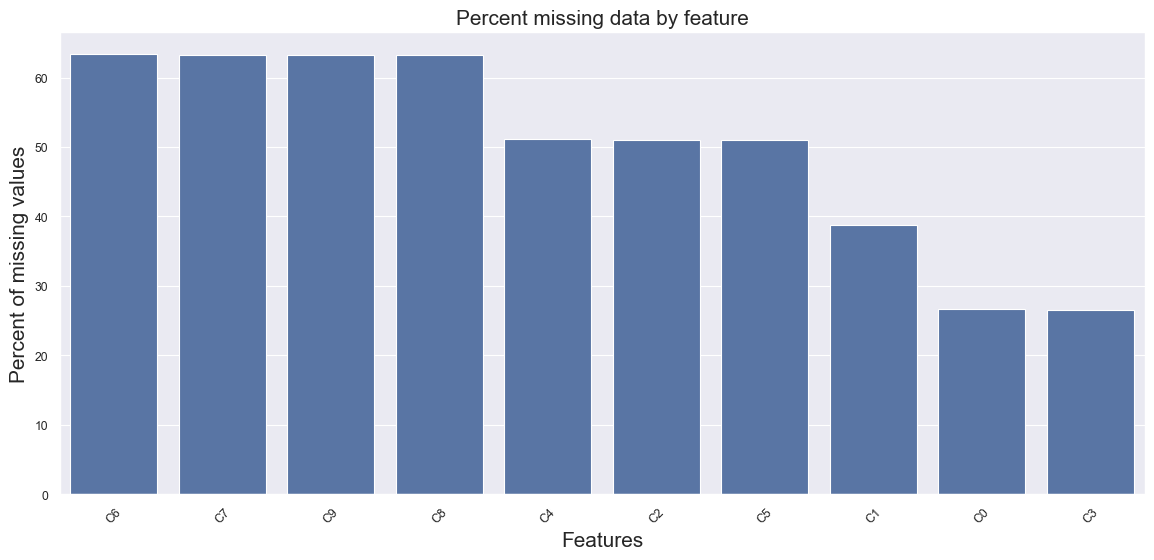

In [23]:
all_data_na = (df_pivot.isnull().sum() / len(df_pivot)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})

print(missing_data.head(20))

f, ax = plt.subplots(figsize=(14, 6))
plt.xticks(rotation=45)
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

* In my original data, each row represents a transaction: a specific cohort's spending on a particular stock on a given date. However, not every cohort spends on every stock every day. Therefore, certain combinations of date, stock, and cohort don't exist in the original data. We can treat these missing values as 0 spending. Since a missing value indicates that a cohort did not spend on a particular stock on a specific date, it is logical to treat these NaN values as zeros. This approach maintains the integrity of the dataset by accurately representing the absence of spending.

In [24]:
df_pivot = df_pivot.fillna(0)

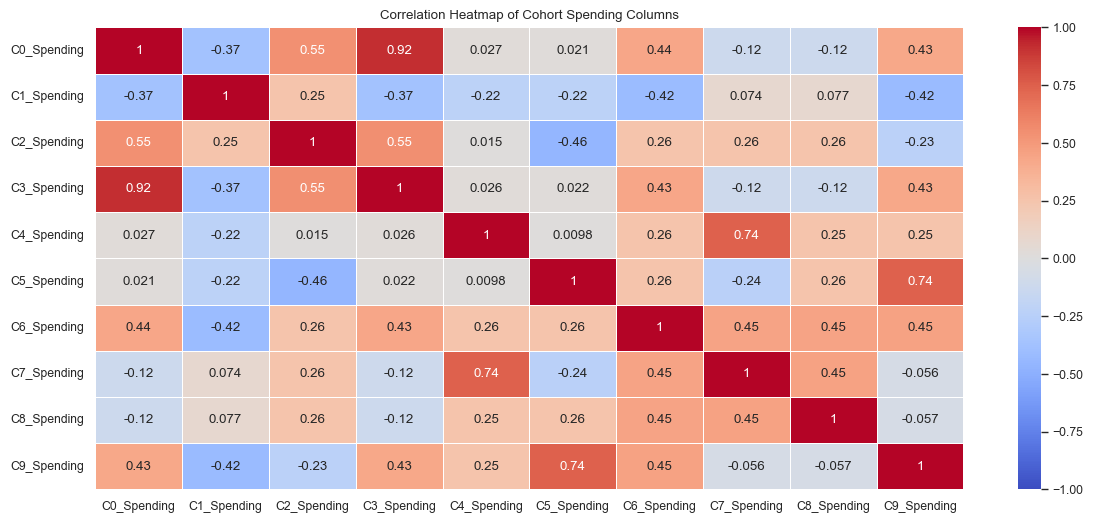

In [25]:
df_pivot.columns = ['date', 'stock', 'C0_Spending', 'C1_Spending', 'C2_Spending', 'C3_Spending', 'C4_Spending', 'C5_Spending', 'C6_Spending', 'C7_Spending', 'C8_Spending', 'C9_Spending']
spending_columns = ['C0_Spending', 'C1_Spending', 'C2_Spending',
       'C3_Spending', 'C4_Spending', 'C5_Spending', 'C6_Spending',
       'C7_Spending', 'C8_Spending', 'C9_Spending']

cohort_spending_data = df_pivot[spending_columns]
cohort_spending_data_standardized = (cohort_spending_data - cohort_spending_data.mean())/cohort_spending_data.std()
correlation_matrix = cohort_spending_data_standardized.corr()

plt.figure(figsize=(14, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Cohort Spending Columns')
plt.show()

We see that cohorts (C0,C3) that consistently spend similarly across stocks have high positive correlations, while those with more sporadic spending or different patterns have weaker or negative correlations. 
- C0 and C3 (high correlation 0.91) - when C0 tends to spend more, C3 also tends to the same, and vice-versa. This means similar spending habits, potentially targeting the same sectors/stocks.
- C3 and C2 (moderate correlation 0.55) - while not as strong as the above pair, they appear to share some similar tendencies in their spending.
- C7 and C4 (high correlation 0.74) - the two cohorts share a significant overlap in their spending habits which could be driven by factors like market conditions, economic factors, similar taste in stocks/sectors or they could represent similar demographics.
- C9 and C5 (high correlation 0.74) - same as above.
- The rest of cohorts might be behaving independently.

For forecasting returns, knowing which cohorts' spending are correlated can help us understand which cohorts are moving in tandem and likely amplifying changes in stock returns

#### 6. Response Variable Distribution

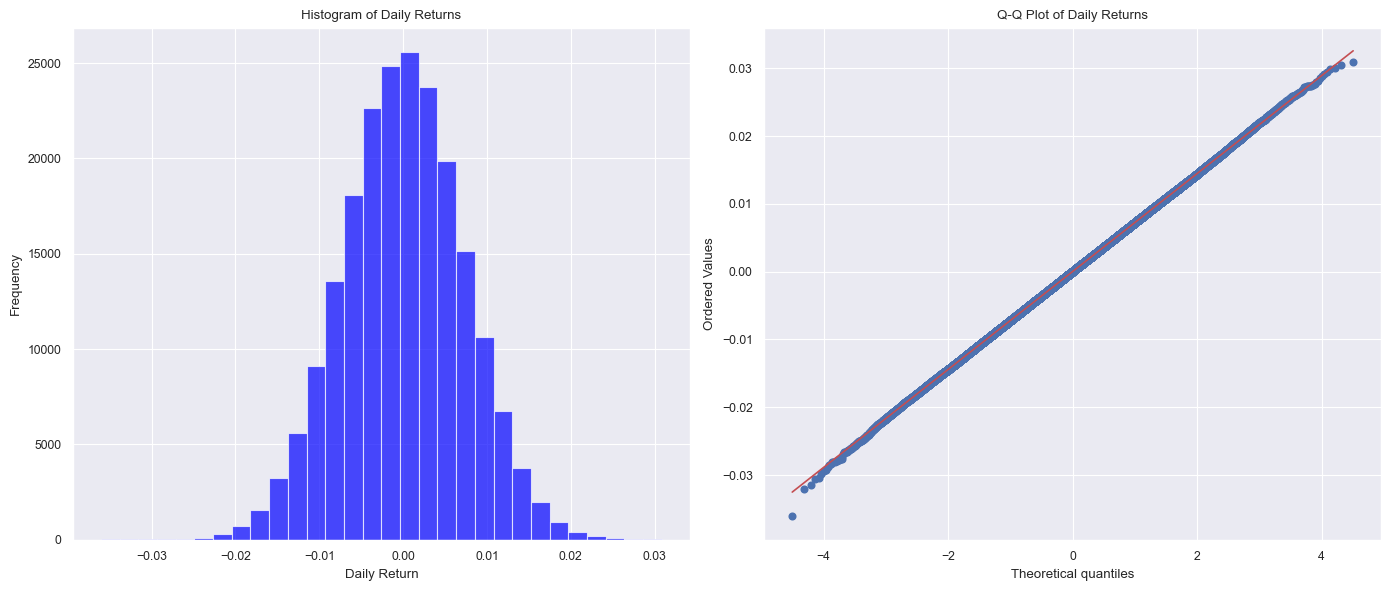

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the histogram on the left
axes[0].hist(stock_returns_df['return'], bins=30, color='blue', alpha=0.7)
axes[0].set_title('Histogram of Daily Returns')
axes[0].set_xlabel('Daily Return')
axes[0].set_ylabel('Frequency')

# Plot the Q-Q plot on the right
stats.probplot(stock_returns_df['return'], plot=plt)
axes[1].set_title('Q-Q Plot of Daily Returns')

plt.tight_layout()
plt.show()

As evident by the plots, the distribution of returns is normally distributed and do not require any transformation. However, the scale of returns and our predictor 'total_spend' raises red flags

In [27]:
stock_returns_df['date'] = pd.to_datetime(stock_returns_df['date'])
df_pivot_returns = stock_returns_df.pivot(index='date', columns='stock', values='return')

print(df_pivot_returns.head())
print(df_pivot_returns.shape)
print(df_pivot_returns.columns)

stock             S0        S1       S10       S11       S12       S13  \
date                                                                     
2015-01-01  0.006677 -0.006529  0.006549 -0.004228  0.006766 -0.001837   
2015-01-02 -0.006601  0.006194  0.000338 -0.007449  0.002910 -0.004937   
2015-01-05  0.000709  0.006535  0.008309 -0.005575 -0.009336  0.004886   
2015-01-06  0.008742 -0.015656 -0.005693  0.008568 -0.006792 -0.000925   
2015-01-07  0.011159  0.000899  0.006446  0.002791 -0.000037 -0.006712   

stock            S14       S15       S16       S17  ...       S90       S91  \
date                                                ...                       
2015-01-01  0.007026  0.001496  0.007936  0.006783  ...  0.009666 -0.012755   
2015-01-02  0.009110 -0.014473 -0.002396 -0.002137  ...  0.000836  0.002639   
2015-01-05  0.003060 -0.003505 -0.000373  0.004092  ... -0.005701 -0.003398   
2015-01-06  0.009182 -0.005795  0.007378  0.010882  ... -0.007711  0.011946   
2015-01

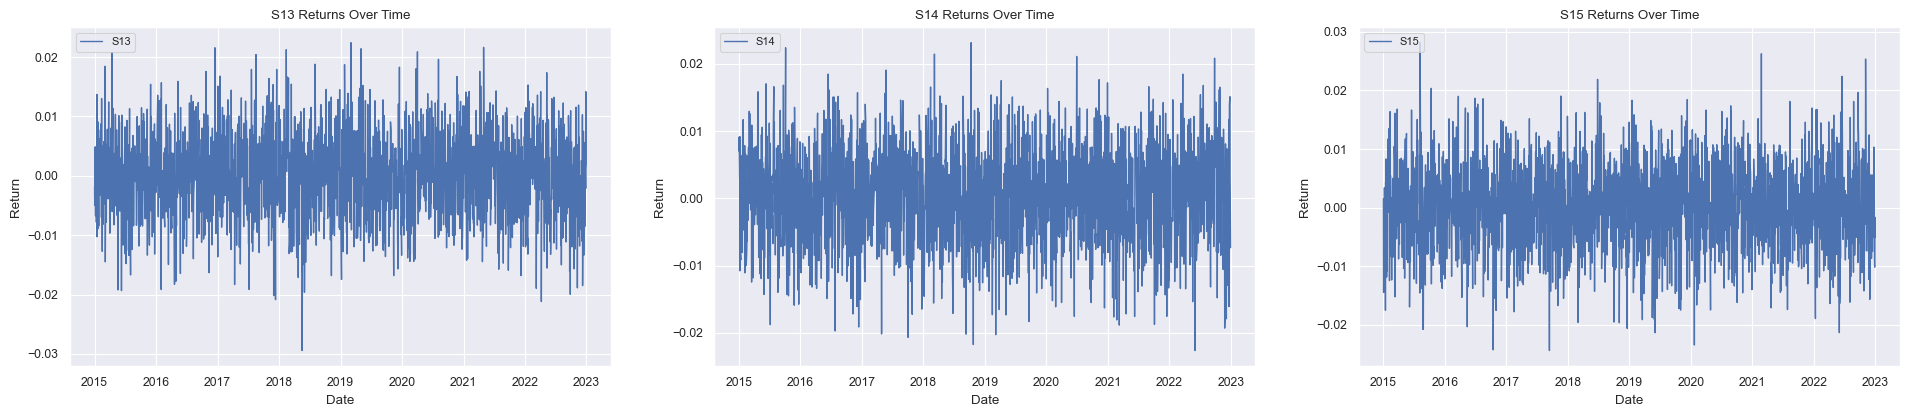

In [28]:
subset_stocks = df_pivot_returns.columns[5:8]

fig, axes = plt.subplots(1, 3, figsize=(20, 5)) 
fig.tight_layout(pad=5)

for i, stock in enumerate(subset_stocks):
    axes[i].plot(df_pivot_returns.index, df_pivot_returns[stock], label=stock, linewidth=1)
    axes[i].set_title(f'{stock} Returns Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Return')
    axes[i].legend(loc='upper left', fontsize='small')
    axes[i].grid(True)

plt.show()

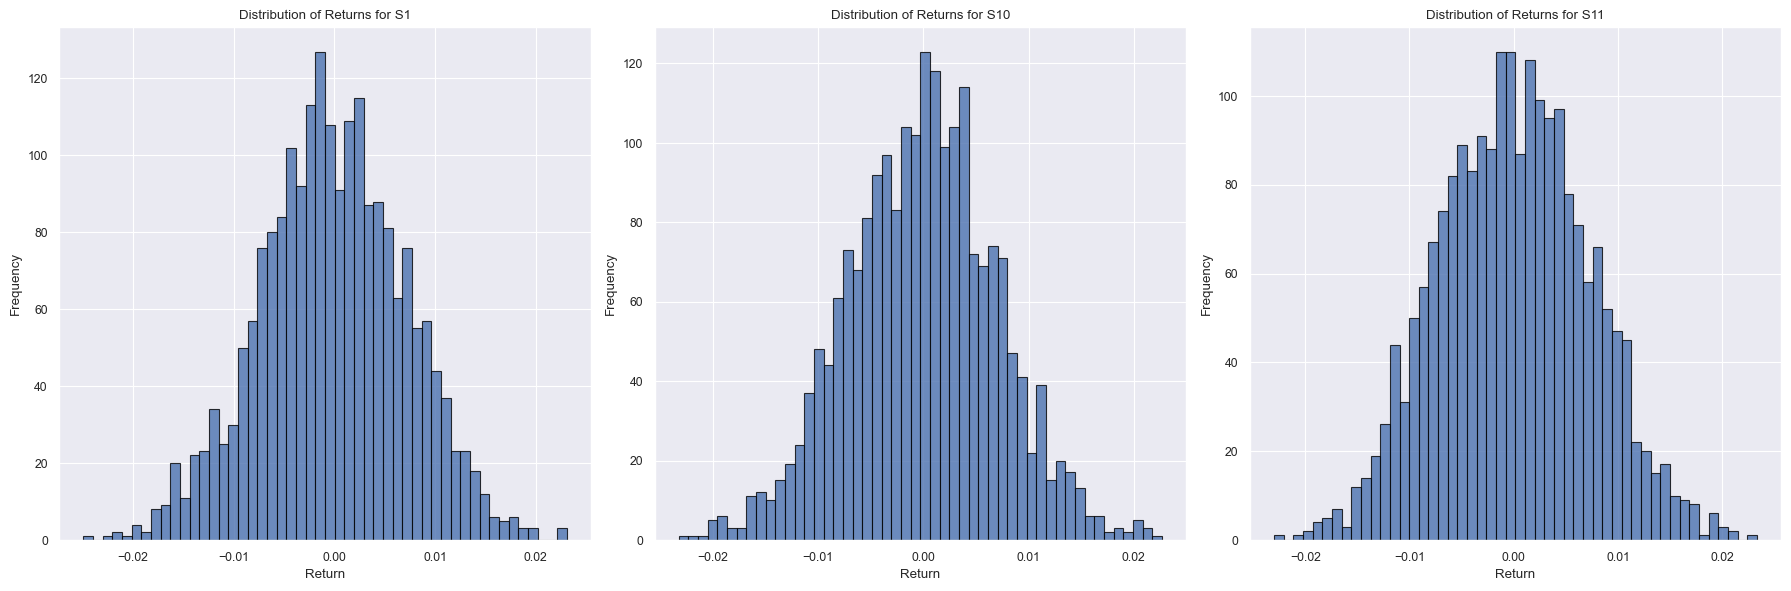

In [29]:
stocks_to_plot = df_pivot_returns.columns[1:4]

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, stock in enumerate(stocks_to_plot):
    ax[i].hist(df_pivot_returns[stock], bins=50, edgecolor='black', alpha = 0.8)
    ax[i].set_title(f'Distribution of Returns for {stock}')
    ax[i].set_xlabel('Return')
    ax[i].set_ylabel('Frequency')
    ax[i].grid(True)

plt.tight_layout()
plt.show()

The range of the returns is quite narrow - approximately +/- 0.02 for all stocks. Since the variation between returns is minimal, this means the correlation values between returns are on the lower side. Correlations tend to be sensitive to both the magnitude and direction of movement. But they do appear to follow a normal distribution which is common for financial returns. 

#### Total Spend per Stock across all cohorts

In [30]:
df_pivot1 = credit_card_spending_df.pivot_table(
    index=['date', 'stock'],
    columns=['cohort'],
    values='transformed_spend',
    aggfunc='sum'
).reset_index()

columns_to_merge = ['date', 'stock', 'missing_spend', 'GICS sector']

# Dropping duplicates to avoid conflicts during merge
additional_columns = credit_card_spending_df[columns_to_merge].drop_duplicates(subset=['date', 'stock'])

# Merging the additional columns back into the pivoted DataFrame
df_pivot_full = df_pivot1.merge(
    additional_columns,
    on=['date', 'stock'],
    how='left'  # Left join to retain all rows in df_pivot and add additional columns
)
df_pivot_full = df_pivot_full.fillna(0)
df_pivot_full = df_pivot_full.rename(columns={'C0' : 'C0_Spending', 'C1' : 'C1_Spending', 'C2' : 'C2_Spending', 'C3' : 'C3_Spending', 'C4' : 'C4_Spending' , 'C5' : 'C5_Spending', 'C6' : 'C6_Spending', 'C7' : 'C7_Spending', 'C8' : 'C8_Spending',
       'C9' : 'C9_Spending'})

df_pivot_full['total_spend'] = df_pivot_full[[col for col in df_pivot.columns if 'Spending' in col]].sum(axis=1)
df_pivot_full['active_cohorts'] = (df_pivot_full[spending_columns] > 0).sum(axis=1)

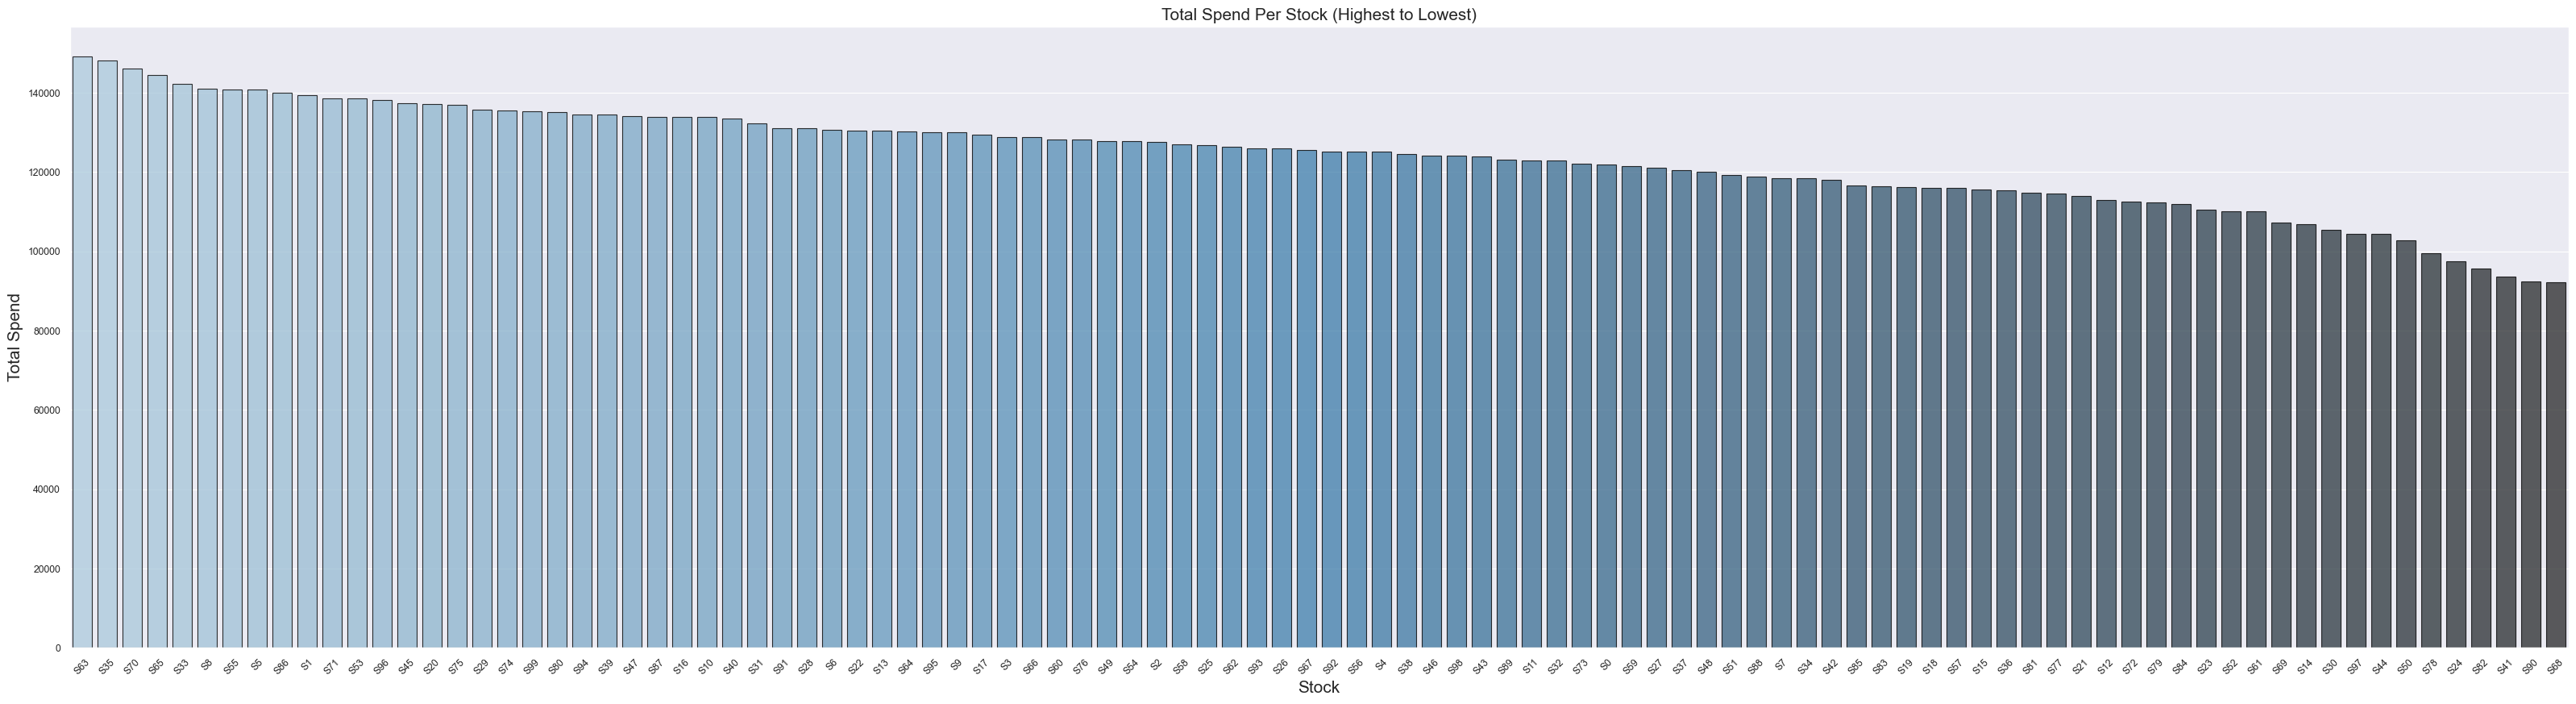

In [31]:
total_spend_per_stock = df_pivot_full.loc[:, 'C0_Spending':'C9_Spending'].sum(axis=1)
df_pivot_full['Total_Spending'] = total_spend_per_stock

# Group by 'stock' and sum the 'Total_Spending' for each stock
stock_total_spend = df_pivot_full.groupby('stock')['Total_Spending'].sum().sort_values(ascending=False)

# Create a bar plot for total spend per stock from highest to lowest
plt.figure(figsize=(40, 10))
sns.barplot(x=stock_total_spend.index, y=stock_total_spend.values, palette='Blues_d', edgecolor='black', alpha = 0.8)
plt.xticks(rotation=45)
plt.xlabel('Stock', fontsize=15)
plt.ylabel('Total Spend', fontsize=15)
plt.title('Total Spend Per Stock (Highest to Lowest)', fontsize=15)
plt.show()

Top 3 Highest spend stocksa are S63, S35, S70 and top 3 lowest spend are S41, S90, S68

<a name="spend_time_series"></a>
## Constructing the Spend Time Series <div id='spend_time_series'>

<a name="spend_data"></a>
### Aggregate Spend Data and Plot Time Series <div id='spend_data'>

In [32]:
# calculate the correlation
corr_val = df_pivot_full['total_spend'].corr(df_pivot_full['active_cohorts'])
print(f'Correlation between Total Spend and Active Cohorts: {corr_val}')

Correlation between Total Spend and Active Cohorts: 0.9508976237854422


Since there are 100 stocks, I am not going to plot everything except the top 3 highest spend and top 3 lowest spend stocks from the plot [Total Spend per Stock](#total-spend-per-stock)

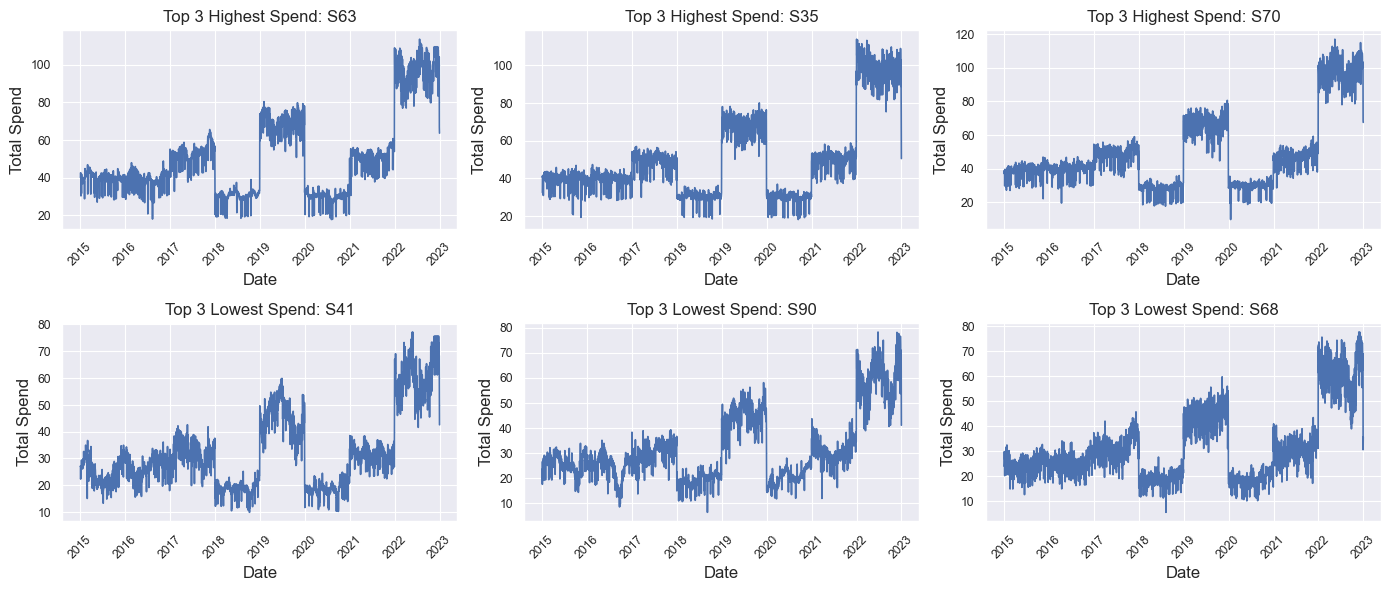

In [33]:
daily_stock_spend = df_pivot_full.groupby(['date', 'stock'])['total_spend'].sum().reset_index()
time_series_df = daily_stock_spend.pivot(index='date', columns='stock', values='total_spend')

#reorder
time_series_df = time_series_df[['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
       'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19',
       'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28',
       'S29', 'S30', 'S31', 'S32', 'S33', 'S34', 'S35', 'S36', 'S37',
       'S38', 'S39', 'S40', 'S41', 'S42', 'S43', 'S44', 'S45', 'S46',
       'S47', 'S48', 'S49', 'S50', 'S51', 'S52', 'S53', 'S54', 'S55',
       'S56', 'S57', 'S58', 'S59', 'S60', 'S61', 'S62', 'S63', 'S64',
       'S65', 'S66', 'S67', 'S68', 'S69', 'S70', 'S71', 'S72', 'S73',
       'S74', 'S75', 'S76', 'S77', 'S78', 'S79', 'S80', 'S81', 'S82',
       'S83', 'S84', 'S85', 'S86', 'S87', 'S88', 'S89', 'S90', 'S91',
       'S92', 'S93', 'S94', 'S95', 'S96', 'S97', 'S98', 'S99']]
time_series_df.head(5)

top_3_highest_stocks = stock_total_spend.reset_index()['stock'].head(3)
top_3_lowest_stocks = stock_total_spend.reset_index()['stock'].tail(3)

# Filter the time-series data for the top 3 highest and lowest spend stocks
stocks_to_plot = list(top_3_highest_stocks) + list(top_3_lowest_stocks)
filtered_time_series_df = time_series_df[stocks_to_plot]

fig, ax = plt.subplots(2, 3, figsize=(14, 6))

for i, stock in enumerate(stocks_to_plot[:3]):
    ax[0, i].plot(filtered_time_series_df.index, filtered_time_series_df[stock])
    ax[0, i].set_title(f'Top 3 Highest Spend: {stock}',fontsize = 12)
    ax[0, i].set_xlabel('Date',fontsize = 12)
    plt.xticks(rotation = 45)
    ax[0, i].set_ylabel('Total Spend',fontsize = 12)
    ax[0, i].grid(True)
        # Set x-ticks rotation for each subplot
    for label in ax[0, i].get_xticklabels():
        label.set_rotation(45)

for i, stock in enumerate(stocks_to_plot[3:]):
    ax[1, i].plot(filtered_time_series_df.index, filtered_time_series_df[stock])
    ax[1, i].set_title(f'Top 3 Lowest Spend: {stock}', fontsize = 12)
    ax[1, i].set_xlabel('Date',fontsize = 12)
    ax[1, i].set_ylabel('Total Spend',fontsize = 12)
    ax[1, i].grid(True)
    # Set x-ticks rotation for each subplot
    for label in ax[1, i].get_xticklabels():
        label.set_rotation(45)

plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

Some of my observations for the Top 3 Highest Spend Stocks:
* Trend: All three stocks exhibit a gradual increase in total spend over time, with noticeable spikes around 2020 and 2021, potentially due to changes in market/consumer behavior (possibly related to external factors like the pandemic or economic changes)

Top 3 Lowest Spend:
* Trend: The overall trend for the lowest spend stocks shows smaller, gradual increases, but they do exhibit notable upward shifts starting around 2021.This could suggest that while these stocks aren't in high demand, they still experienced some growth or recovery post-2020.

The higher spend stocks exhibit greater volatility and sharper peaks, particularly after 2020, whereas the lower spend stocks have a smoother and more consistent pattern with smaller peaks. Each stock seems to exhibit unique behavior, with certain stocks showing consistent upward trends (e.g., S63, S35) while others like S41 and S90 have relatively flat trends with smaller fluctuations.



Next Step
> We can analyze trend and seasonality of each time series by decomposing it to explore any underlying trends and seasonal components using the seasonal_decompose function from statsmodels

<a name="active_cohort_analysis"></a>
### Analyze Relationship with Active Cohorts <div id='active_cohort_analysis'>

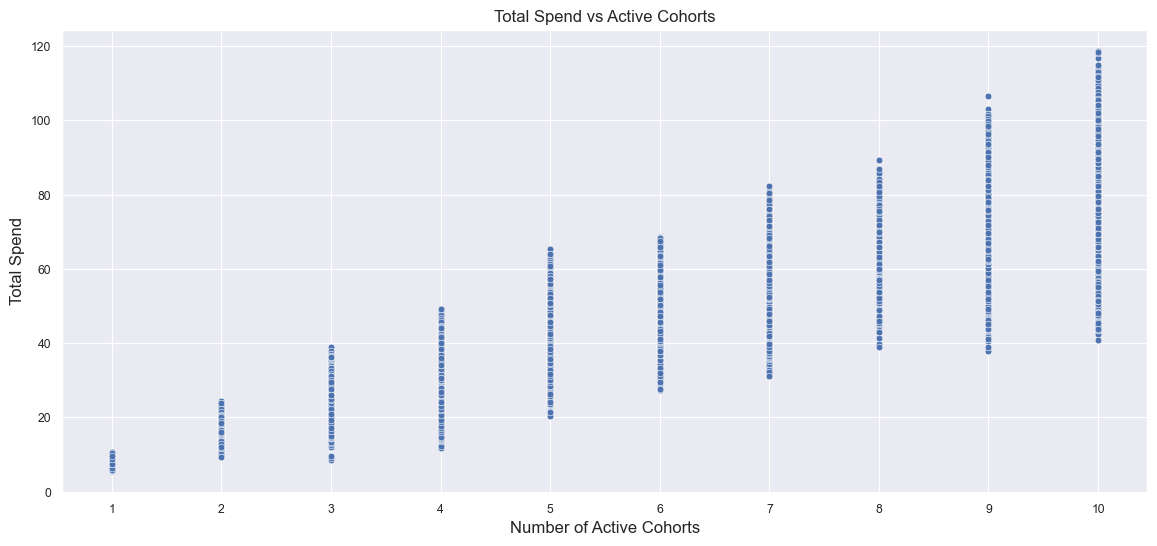

In [34]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x='active_cohorts', y='total_spend', data=df_pivot_full)
plt.title('Total Spend vs Active Cohorts', fontsize = 12)
plt.xticks(range(1,11))
plt.xlabel('Number of Active Cohorts', fontsize = 12)
plt.ylabel('Total Spend', fontsize = 12)
plt.show()

A correlation of 0.95 suggests that the number of active cohorts (cohorts with non-zero spending for a given stock on a given day) increases, the total spend for a stock also increases significantly as confirmed by the plot above. This implies that when more cohors are spending on a particular stock, the overall spending is higher. In the context of our forecasting problem, this could mean that the number of active cohorts is a good predictor of total spend since if a a stock is receiving attention from multiple cohorts (e.g. investors or consumers), it results in more spending. From Plot 4, we saw how C3, C0, C1 were the most active cohorts

Next Step
> We can look at Cohort Influence on Specific Sectors



Cohort C0_Spending and Sector 10 correlation: -0.006
Cohort C1_Spending and Sector 10 correlation: -0.012
Cohort C2_Spending and Sector 10 correlation: 0.011
Cohort C3_Spending and Sector 10 correlation: -0.009
Cohort C4_Spending and Sector 10 correlation: 0.030
Cohort C5_Spending and Sector 10 correlation: -0.004
Cohort C6_Spending and Sector 10 correlation: 0.027
Cohort C7_Spending and Sector 10 correlation: 0.039
Cohort C8_Spending and Sector 10 correlation: 0.050
Cohort C9_Spending and Sector 10 correlation: -0.015
Cohort C0_Spending and Sector 20 correlation: -0.005
Cohort C1_Spending and Sector 20 correlation: 0.026
Cohort C2_Spending and Sector 20 correlation: 0.012
Cohort C3_Spending and Sector 20 correlation: -0.013
Cohort C4_Spending and Sector 20 correlation: -0.025
Cohort C5_Spending and Sector 20 correlation: 0.006
Cohort C6_Spending and Sector 20 correlation: -0.002
Cohort C7_Spending and Sector 20 correlation: -0.008
Cohort C8_Spending and Sector 20 correlation: 0.019
Co

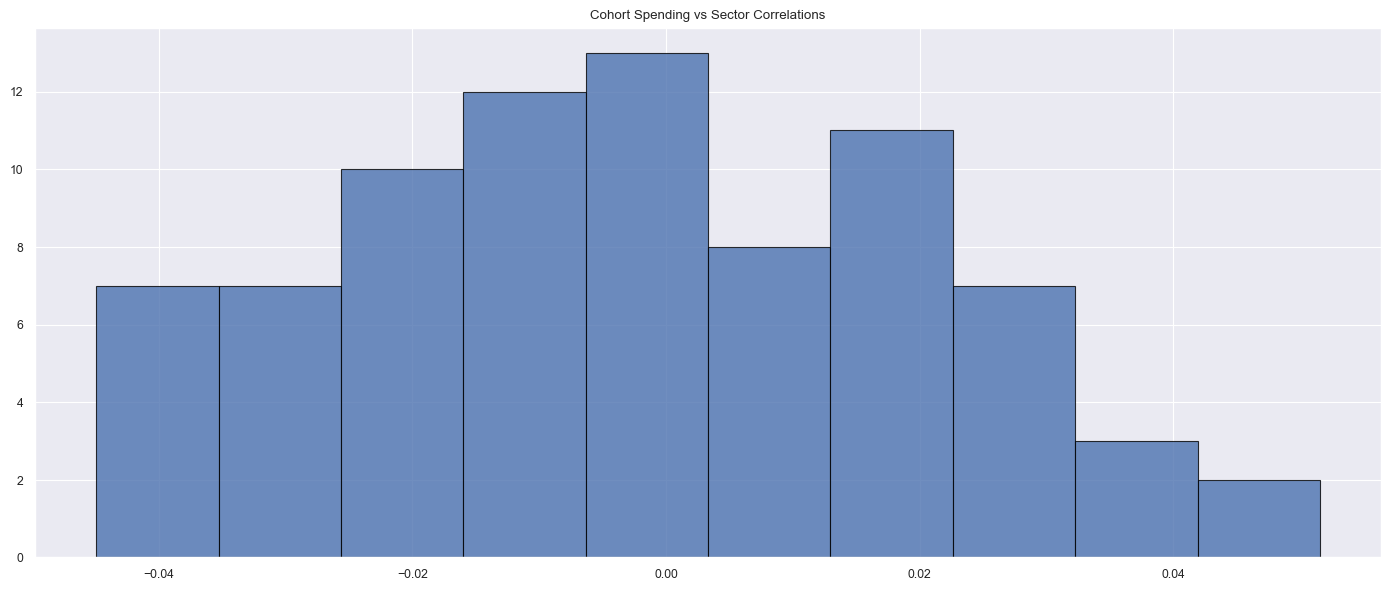

In [35]:
cohort_sector_spend = df_pivot_full.groupby('GICS sector')[['C0_Spending', 'C1_Spending', 'C2_Spending',
                                                            'C3_Spending', 'C4_Spending', 'C5_Spending',
                                                            'C6_Spending', 'C7_Spending', 'C8_Spending',
                                                            'C9_Spending']].sum()
corr_vals = []
# Loop through each sector and align it with relevant stocks in df_pivot_returns
for sector in cohort_sector_spend.index:
    
    # Identify stocks associated with the current GICS sector
    stocks_in_sector = df_pivot_full[df_pivot_full['GICS sector'] == sector]['stock'].unique()
    
    # Calculate the average returns for stocks in this sector
    sector_returns = df_pivot_returns[stocks_in_sector].mean(axis=1)
    
    # Loop through each cohort and calculate the correlation with the sector returns
    for cohort in cohort_sector_spend.columns:
        
        # Get cohort spending data for the current sector
        cohort_spending = df_pivot_full[df_pivot_full['GICS sector'] == sector][cohort].groupby(df_pivot_full['date']).sum()
        
        # Align data
        aligned_data = pd.concat([cohort_spending, sector_returns], axis=1).dropna()

        if not aligned_data.empty:
            correlation = aligned_data.iloc[:, 0].corr(aligned_data.iloc[:, 1])
            corr_vals.append(correlation)
            print(f"Cohort {cohort} and Sector {sector} correlation: {correlation:.3f}")
        else:
            print(f"No valid data for correlation between Cohort {cohort} and Sector {sector}.")

plt.figure(figsize=(14, 6))
plt.hist(corr_vals, edgecolor='black', alpha = 0.8)
plt.title("Cohort Spending vs Sector Correlations")
plt.tight_layout()
plt.show()

The plot shows that the weak correlations indicate the impact of cohort spending on stock returns may not be immediate. By introducing lagged spending data (e.g., spending from the previous week or month), we might uncover stronger relationships.

<a name="seasonality_correction"></a>
## Seasonality Analysis and Correction <div id='seasonality_correction'>

<a name="detect_seasonality"></a>
### Detect Seasonality <div id='detect_seasonality'>

<a name="decomposition"></a>
#### Time-Series Decomposition <div id='decomposition'>

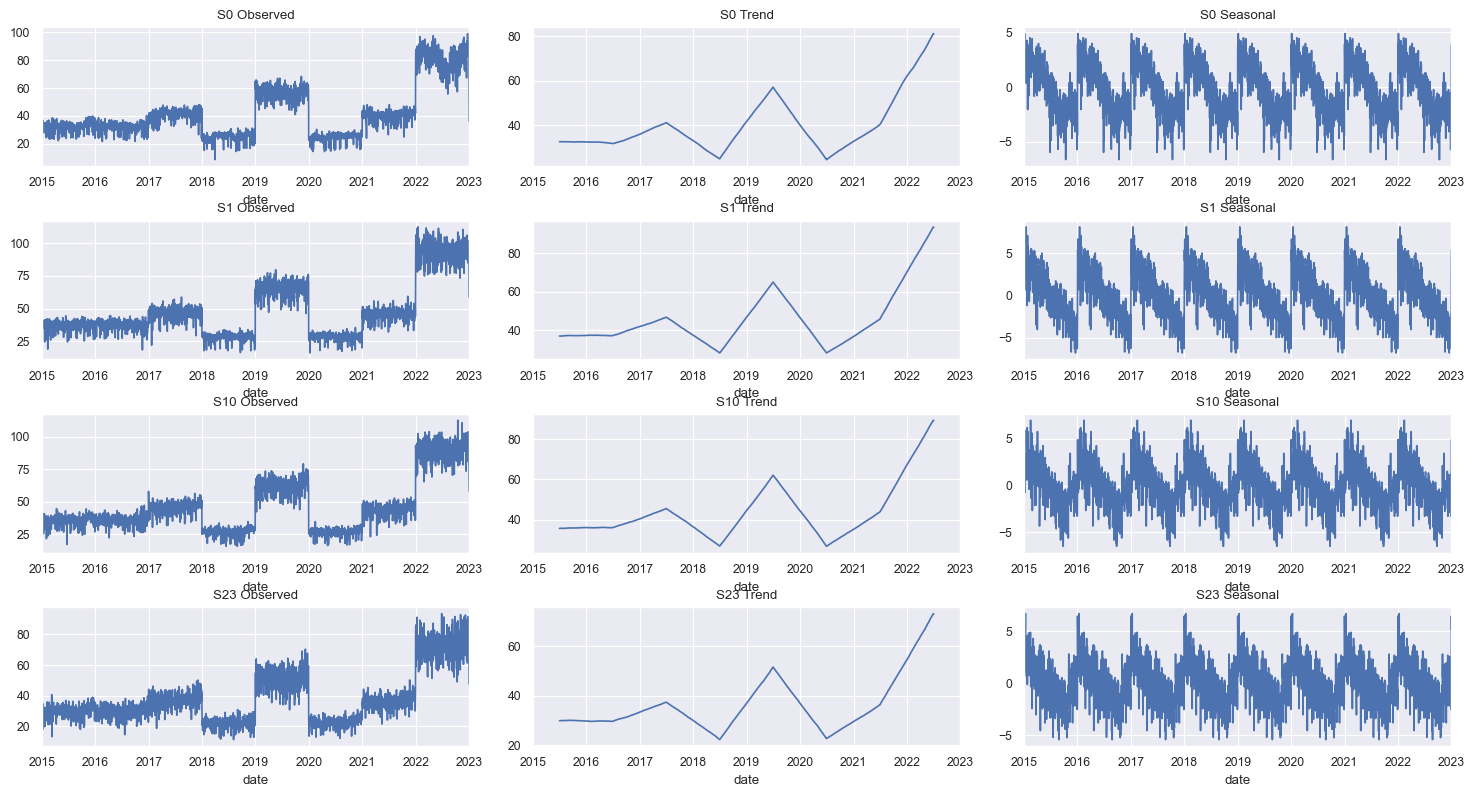

In [36]:
subset_stocks = ['S0', 'S1', 'S10', 'S23']

fig, axes = plt.subplots(4, 3, figsize=(15, 8))
fig.tight_layout(pad=2)

# Iterate over the selected stocks to perform decomposition
for i, stock in enumerate(subset_stocks):
    stock_data = df_pivot_full[df_pivot_full['stock'] == stock].set_index('date')['total_spend'].dropna()

    # Perform seasonal decomposition
    decomposition = seasonal_decompose(stock_data, model='additive', period=365)

    decomposition.observed.plot(ax=axes[i, 0], title=f'{stock} Observed', legend=False)
    decomposition.trend.plot(ax=axes[i, 1], title=f'{stock} Trend', legend=False)
    decomposition.seasonal.plot(ax=axes[i, 2], title=f'{stock} Seasonal', legend=False)

plt.show()

Some observations for Yearly Seasonality
- Same trends mentioned in **Detect Seasonality Plot** and **Trends and Seasonality in Spending (By Month, Quarter, Year)** are all evident in the plots above.
- Looking at the seasonal column to the right, we observe repeating cycles for all stocks every year similar peaks and troughs which likely coincide with economical events such as Q1-Q2 tax refunds with slowdown in spending after holidays and Q4 holiday season or fiscal quarters, thus total spend follows a regular pattern annually. 

<a name="autocorrelation_analysis"></a>
#### Autocorrelation Analysis <div id='autocorrelation_analysis'>

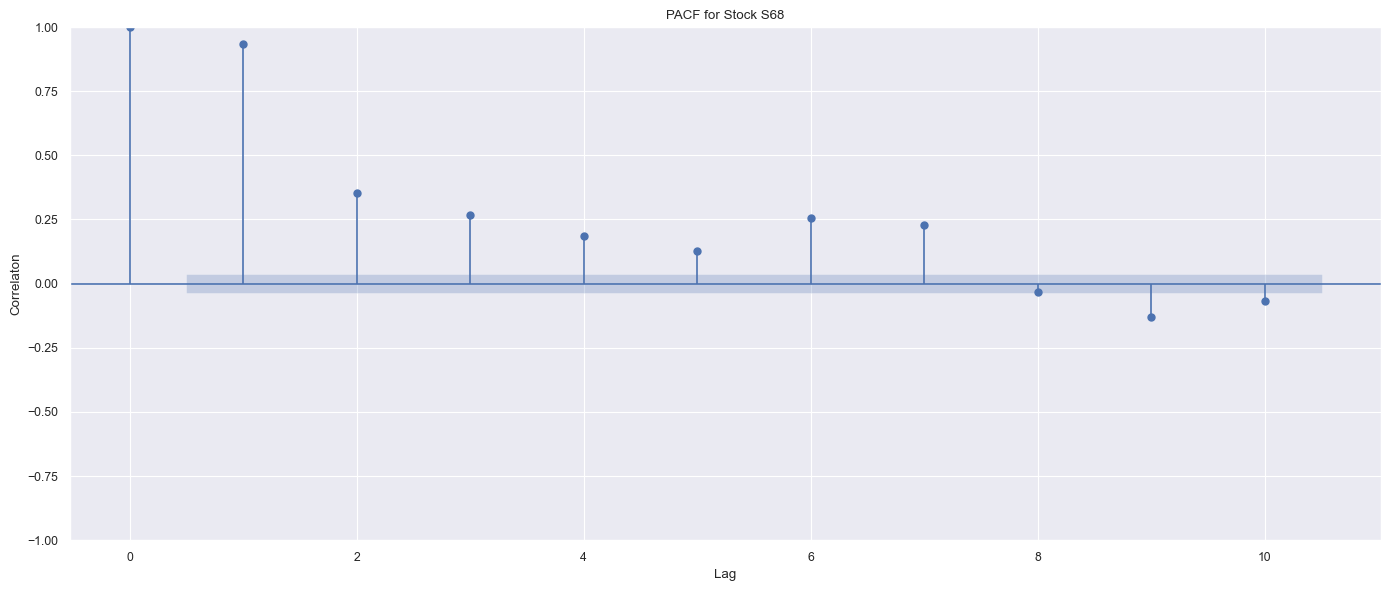

In [37]:
stock = 'S68'
stock_data = time_series_df[stock].dropna()  # Get the total log spend for the selected stock

fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# PACF plot (shows partial autocorrelation)
plot_pacf(stock_data, lags=10, ax=ax)  # Adjust 'lags' as needed
ax.set_title(f'PACF for Stock {stock}')
ax.set_xlabel("Lag")
ax.set_ylabel("Correlaton")

plt.tight_layout()
plt.show()

In PACF, We observe significant spikes for the first three lags, indicating that these lags are important for predicting future values. After lag 3, the partial autocorrelations quickly taper off and stay close to 0, suggesting that after accounting for the first few lags, further lagged values don’t provide much additional information.

<a name="implement_correction"></a>
### Baseline Modeling - Implement Seasonality Correction <div id='implement_correction'>

Most linear regression-based models assume that the predictors (independent variables) are normally distributed. Non-normality can lead to inefficiencies and biases in parameter estimates. Hence, before we proceed, we need to calculate a few statistics to prepare our data for baseline modeling. 

#### Calculate some Statistics

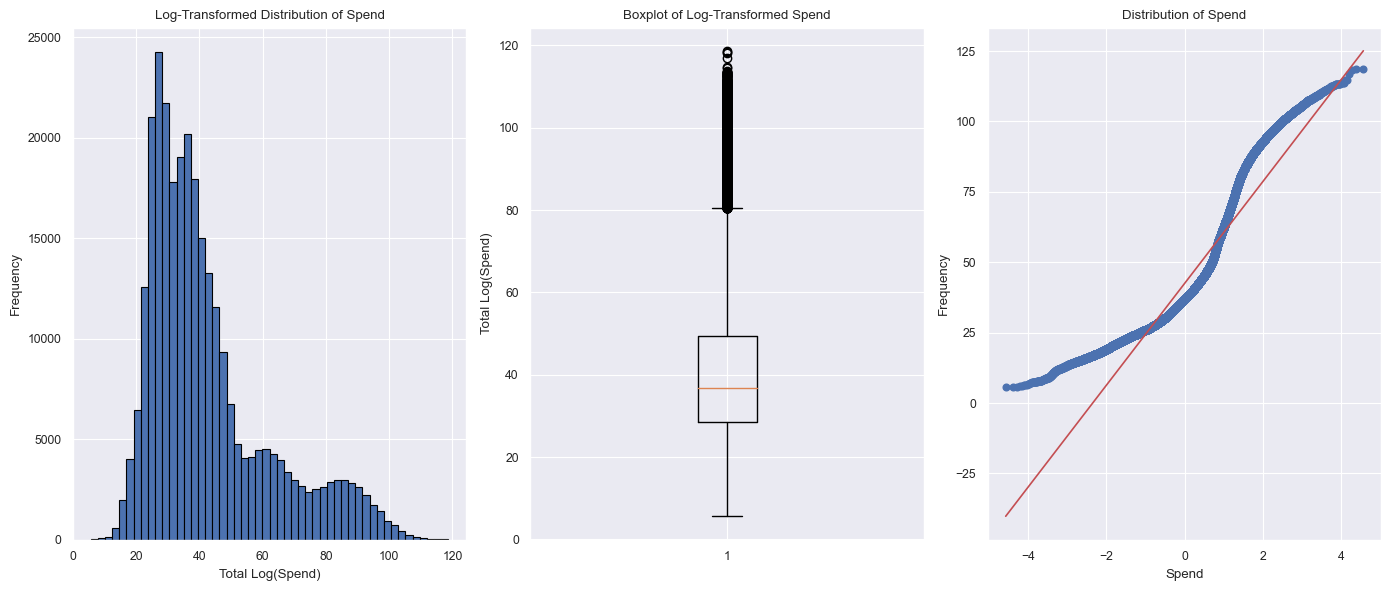

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

ax[0].hist(df_pivot_full.total_spend, bins=50, edgecolor='black')
ax[0].set_title('Log-Transformed Distribution of Spend')
ax[0].set_xlabel('Total Log(Spend)')
ax[0].set_ylabel('Frequency')

ax[1].boxplot(df_pivot_full.total_spend)
ax[1].set_title('Boxplot of Log-Transformed Spend')
ax[1].set_ylabel('Total Log(Spend)')

stats.probplot(df_pivot_full.total_spend, plot=plt)
ax[2].set_title('Distribution of Spend')
ax[2].set_xlabel('Spend')
ax[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [39]:
time_series_df.describe()

stock,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S90,S91,S92,S93,S94,S95,S96,S97,S98,S99
count,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,...,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2923.000000,2922.000000,2923.000000,2923.000000
mean,41.713251,47.695573,43.643322,44.107235,42.794304,48.154278,44.692881,40.552440,48.272648,44.510689,...,31.587402,44.866652,42.843543,43.109754,46.041998,44.512459,47.301900,35.727939,42.450281,46.270771
std,18.343596,21.091692,19.425800,19.761475,19.941611,20.912580,20.900123,18.551365,20.661079,19.640014,...,13.516206,19.068791,18.566798,19.134369,20.470486,19.542453,20.612109,16.080303,18.771951,20.353668
min,8.662914,16.113745,8.452498,8.844660,7.457023,8.804567,8.526978,7.394275,10.298962,7.981830,...,6.355482,9.017115,14.773599,15.130492,8.934991,14.204483,16.282221,7.021788,7.538248,8.822386
25%,27.922278,31.407801,28.519877,29.189811,27.891386,31.326023,29.517263,26.603310,31.999087,29.703193,...,21.847151,29.411585,29.012516,28.512229,30.382474,29.198550,31.186355,24.005290,27.732271,30.614542
50%,35.991651,40.897232,37.479266,37.876532,36.015401,40.781846,37.623770,34.243376,41.420386,38.970810,...,27.661565,39.086835,37.083905,37.265077,38.872306,38.804928,40.678501,30.767465,36.852122,39.839874
75%,47.115641,53.694832,49.448704,48.888232,48.604314,55.211635,51.958920,46.057054,54.442030,50.413934,...,37.261274,51.188019,47.865419,49.351752,52.784697,51.612925,53.438486,41.789245,48.567343,52.699709
max,99.031001,112.348027,101.694604,107.472651,101.932342,107.630266,111.652996,102.024848,110.497148,105.770408,...,78.229277,105.453847,104.855835,102.135862,110.137026,100.243488,107.807805,96.562681,98.696523,110.741047


Extreme values and skewed distributions tend to disproportionately affect the Pearson correlation coefficient. Since the scales of my predictor and response are different, I will calculate the skewness and kurtosis of each to see if response has potentially a different skewness and kurtosis compared to the predictor.

Skewness measures the asymmetry of the probability distribution of a real-valued random variable about its mean.
* S1: -0.050331 — Slightly left-skewed, but very close to zero, suggesting a nearly symmetric distribution.
* S10: -0.015338 — Also slightly left-skewed, nearly symmetric.
* S11: 0.050618 — Slightly right-skewed, but again, nearly symmetric.

Kurtosis measures the tailedness of the probability distribution of a real-valued random variable
* S1: -0.051587 — Slightly negative excess kurtosis, indicating a platykurtic distribution which is somewhat flatter than a normal distribution with thinner tails.
* S10: 0.066547 — Slightly positive excess kurtosis, suggesting a leptokurtic distribution but very close to normal, indicating slightly fatter tails.
* S11: -0.221550 — Noticeable negative excess kurtosis, more platykurtic than S1, indicating a flatter distribution with thinner tails compared to a normal distribution.

In [40]:
# Calculate skewness and kurtosis for each stock
stats_list = {}
random_subset_stocks = ['S1', 'S10', 'S11']
for stock in random_subset_stocks:
    stock_skewness = skew(df_pivot_returns[stock])
    stock_kurtosis = kurtosis(df_pivot_returns[stock])
    stats_list[stock] = {'Skewness': stock_skewness, 'Kurtosis': stock_kurtosis}

# Convert the stats dictionary to a DataFrame for better visualization
stats_df = pd.DataFrame(stats_list).T  # Transpose for better formatting
print(stats_df)

     Skewness  Kurtosis
S1  -0.050331 -0.051587
S10 -0.015338  0.066547
S11  0.050618 -0.221550


 The Response variable is already fairly symmetrical and lacks significant skewness or extreme kurtosis that would typically necessitate any transformations.

In [41]:
skewness_sc = skew(df_pivot_full['total_spend'])
kurtosis_sc = kurtosis(df_pivot_full['total_spend'])
print(f"Skewness (SciPy): {skewness_sc}")
print(f"Kurtosis (SciPy): {kurtosis_sc}")

Skewness (SciPy): 1.2297418157352735
Kurtosis (SciPy): 0.8404894732169712


Despite the Box-Cox transformation, which is meant to help normalize the data, the distribution still shows more frequent occurrences of smaller values and fewer occurrences of high values. This right skew suggests that there are days with unusually high spending that are not typical of the general pattern.

In [42]:
time_series_df = time_series_df.fillna(0)

# Apply seasonal adjustment to each stock in time_series_df
seasonally_adjusted_df = pd.DataFrame()

for stock in time_series_df.columns:
    print(f"Seasonally adjusting stock: {stock}")
    seasonally_adjusted_df[stock] = seasonally_adjust_series(time_series_df[stock])
seasonally_adjusted_df.head(5)

Seasonally adjusting stock: S0
Seasonally adjusting stock: S1
Seasonally adjusting stock: S2
Seasonally adjusting stock: S3
Seasonally adjusting stock: S4
Seasonally adjusting stock: S5
Seasonally adjusting stock: S6
Seasonally adjusting stock: S7
Seasonally adjusting stock: S8
Seasonally adjusting stock: S9
Seasonally adjusting stock: S10
Seasonally adjusting stock: S11
Seasonally adjusting stock: S12
Seasonally adjusting stock: S13
Seasonally adjusting stock: S14
Seasonally adjusting stock: S15
Seasonally adjusting stock: S16
Seasonally adjusting stock: S17
Seasonally adjusting stock: S18
Seasonally adjusting stock: S19
Seasonally adjusting stock: S20
Seasonally adjusting stock: S21
Seasonally adjusting stock: S22
Seasonally adjusting stock: S23
Seasonally adjusting stock: S24
Seasonally adjusting stock: S25
Seasonally adjusting stock: S26
Seasonally adjusting stock: S27
Seasonally adjusting stock: S28
Seasonally adjusting stock: S29
Seasonally adjusting stock: S30
Seasonally adjusti

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S90,S91,S92,S93,S94,S95,S96,S97,S98,S99
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,37.246188,41.185980,27.301035,37.112881,36.546873,41.438590,35.870397,31.972301,40.289702,36.702044,...,25.221698,36.952259,40.149501,32.400950,40.748500,39.919790,39.969383,28.806593,25.294745,37.797784
2015-01-02,27.450622,33.559775,28.038214,31.625965,28.324854,29.559254,32.101970,25.760126,35.316563,27.836514,...,14.884675,30.648054,35.534560,21.952851,32.835245,25.807927,31.036024,24.119937,27.292126,30.804209
2015-01-03,29.756830,34.340193,29.230892,37.266473,29.057327,36.097196,32.939015,28.071368,34.683458,32.388991,...,22.901174,30.892488,26.784587,32.532658,35.425484,31.952547,34.441781,23.814020,30.883899,39.355523
2015-01-04,31.451916,33.478752,30.634348,34.388185,29.500178,34.551337,33.817250,30.258588,35.317750,31.224611,...,18.175563,31.941284,36.866538,36.683039,35.254599,30.665378,36.002258,25.714032,26.968615,36.223413
2015-01-05,30.878997,30.190875,28.047673,31.452831,28.964522,35.240688,29.956085,28.734761,26.177886,30.191671,...,20.782950,27.550368,36.495924,31.105684,25.096698,27.381945,33.919111,33.347236,27.633218,32.374358


In [43]:
seasonally_adjusted_df.shape, df_pivot_returns.shape

((2923, 100), (2087, 100))

In [44]:
check_weekend_and_holiday_df(df_pivot_returns.reset_index())
check_weekend_and_holiday_df(seasonally_adjusted_df.reset_index())

(0, 836)

Given the differences in shapes and my goal to ensure that my predictor at time $t$ predicts the future stock return over the period $(t,t+1)$, I will align the datasets first then shift the returns backward by one period.

My thought process
* If we align returns data with spend data, we're effectively introducing data points for dates when no trading activity occurred, leading to potential mismatches or misinterpretations.
* Stock returns are only calculated on trading days (weekdays, excluding market holidays), so aligning the spend data to the returns data ensures we're comparing relevant data.

In [46]:
spending_data = seasonally_adjusted_df[seasonally_adjusted_df.index.dayofweek < 5]
forecast_power, correlations = compute_forecast_power(spending_data,df_pivot_returns, stock_metadata_df)
forecast_power, len(correlations)

(0.802759808845050572, 100)


After ensuring the dates are aligned in predictor and response, no missing values and properly shifting the return series, the forecast power of ~0.8 suggests that the predictor has a strong linear relationship with future returns. This indicates that the current predictor is effectively capturing the information necessary to forecast stock returns accurately.

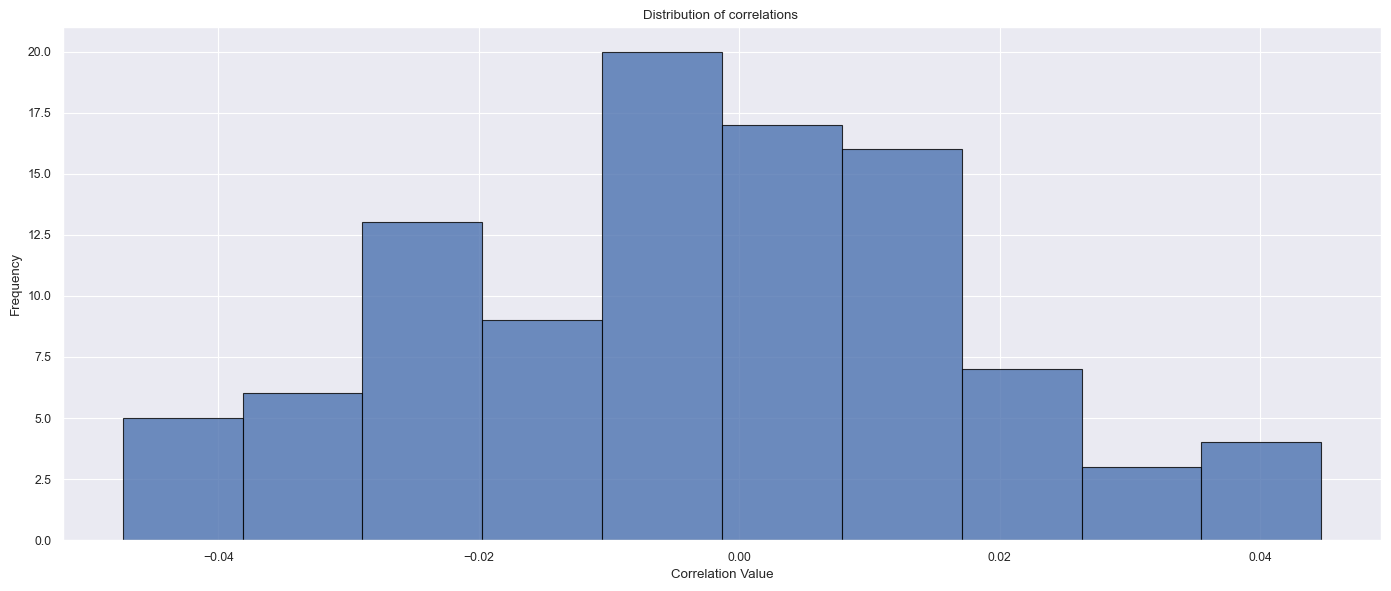

In [60]:
plt.figure(figsize=(14,6))
plt.hist(correlations, bins=10, edgecolor='black', alpha = 0.8)
plt.title("Distribution of correlations ")
plt.xlabel("Correlation Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Now, we need to assess whether the observed correlations are likely due to random chance or if they reflect a genuine underlying relationship by performing a t-test on individual correlations

#### T-Test

In [61]:
results = [correlation_sig_test(r, n=100) for r in correlations]
significant_results = [(index + 1, t, p) for index, (t, p) in enumerate(results) if p < 0.05]

significant_results

[]

<a name="feature_engineering"></a>
## Improving the Baseline Model <div id='feature_engineering'>

In [62]:
spending_data.shape,df_pivot_returns.shape

((2087, 100), (2087, 100))

<a name="smoothing_applied"></a>
### Apply Smoothing Techniques <div id='smoothing_applied'>

In [63]:
forecast_power_smoothed, correlations_smoothed = compute_smoothed_forecast_power(
    spending_data=spending_data, 
    df_pivot_returns=df_pivot_returns, 
    stock_metadata_df=stock_metadata_df, 
    window_size=2
)

Stock: S0
Predictor (after aligning):
date
2015-01-01    37.246188
2015-01-02    27.450622
2015-01-05    30.878997
2015-01-06    25.534249
2015-01-07    28.319896
                ...    
2022-12-23    86.454270
2022-12-26    89.276319
2022-12-27    89.929838
2022-12-28    92.981714
2022-12-29    91.470667
Name: S0, Length: 2086, dtype: float64
Target (after aligning):
date
2015-01-01   -0.006601
2015-01-02    0.000709
2015-01-05    0.008742
2015-01-06    0.011159
2015-01-07    0.005742
                ...   
2022-12-23    0.002628
2022-12-26   -0.022339
2022-12-27    0.003959
2022-12-28   -0.012198
2022-12-29   -0.003076
Name: S0, Length: 2086, dtype: float64
Indices aligned for stock: S0
Stock: S1
Predictor (after aligning):
date
2015-01-01    41.185980
2015-01-02    33.559775
2015-01-05    30.190875
2015-01-06    32.738657
2015-01-07    32.258212
                ...    
2022-12-23    88.926461
2022-12-26    95.135551
2022-12-27    99.094176
2022-12-28    99.924750
2022-12-29    98.32

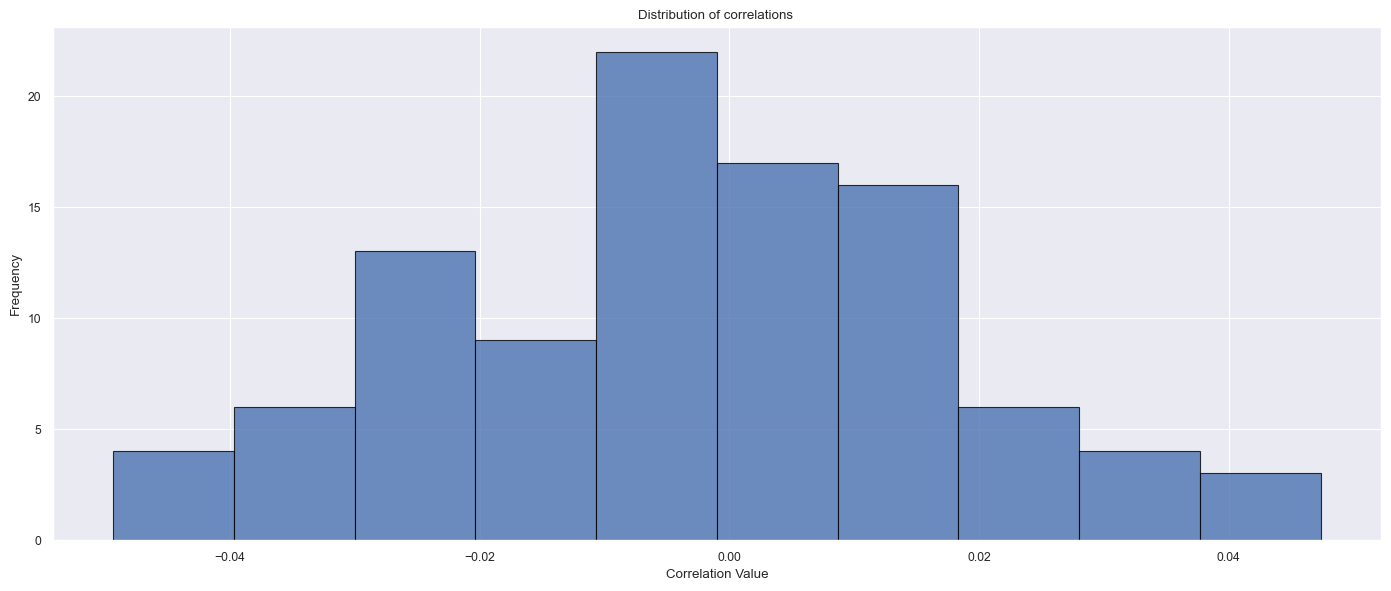

In [65]:
plt.figure(figsize=(14,6))
plt.hist(correlations_smoothed, bins=10, edgecolor='black', alpha = 0.8)
plt.title("Distribution of correlations ")
plt.xlabel("Correlation Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Lag introduced by smoothing could reduce the ability to predict quick changes in stock returns. On the other hand, noise reduction from smoothing might improve the predictive power if the raw spend data was too volatile or noisy in 5b.

Therefore, the smoothed predictor should remove some of the short-term fluctuations or noise in the total spend data. We saw a slight increase in magnitude. If the short-term fluctuations were mostly noise and didn’t align with returns, smoothing them out may improve the predictive signal but nothing drastic, as spend is just one of many factors influencing stock returns.

Stock returns are notoriously hard to predict with any single indicator, so low forecast power is expected in these cases.


<a name="lagged_var"></a>
### Incorporate Lagged Variables <div id='lagged_var'>

Since my target doesnt include values for holidays or weekends but my spending data does - I will drop them as a base case, assuming that there is specific reason to suspect that weekend spending has a deferred impact on stock returns.  <br>

In [66]:
df_pivot_returns['S0']

date
2015-01-01    0.006677
2015-01-02   -0.006601
2015-01-05    0.000709
2015-01-06    0.008742
2015-01-07    0.011159
                ...   
2022-12-26    0.002628
2022-12-27   -0.022339
2022-12-28    0.003959
2022-12-29   -0.012198
2022-12-30   -0.003076
Name: S0, Length: 2087, dtype: float64

In [67]:
lag_list = [5, 7]
stocks_lagged_data = process_all_stocks(spending_data, df_pivot_returns, stock_metadata_df, lag_ls=lag_list, drop_na=True)

data_s0 = stocks_lagged_data['S0']
print(data_s0.head())

                   S0      lag_5      lag_7    target
date                                                 
2015-01-12  28.422154  30.878997  37.246188  0.006018
2015-01-13  29.086725  25.534249  27.450622 -0.002199
2015-01-14  23.994575  28.319896  30.878997  0.006154
2015-01-15  29.710224  35.584202  25.534249  0.004612
2015-01-16  29.061187  29.020218  28.319896 -0.004734


<a name="train_eval"></a>
### Model Training and Evaluation <div id='train_eval'>

In [48]:
results, sector_results = run_time_series_split_regression(stocks_lagged_data, gics_sectors, scale_target=True)
result_df = create_result_table(results['S2'], 6)
result_df

,Metric,Value
0,Model,LinearRegression()
1,RMSE,0.526
2,R-squared,0.64
3,MAE,0.409
4,Durbin-Watson,1.981
5,Jarque-Bera p-value,0.742
6,Coefficients,"[0.005476, 0.003142, -0.001098]"
7,Intercept,0.065324


Selecting one stock, we observe that the model has a relatively high R-squared value, suggesting that it explains a significant portion of the variation in stock returns. This indicates that the predictors (original and lagged) based on credit card spending data are quite effective at forecasting future returns. While the model performs well, additional fine-tuning, such as experimenting with different lag structures or incorporating non-linear models, may further enhance the forecast power.

Since we fit a linear model, it's important that we confirm the assumptions of our regression:
1. Homescedasticity of residuals
2. No Autocorrelation 
3. Normality

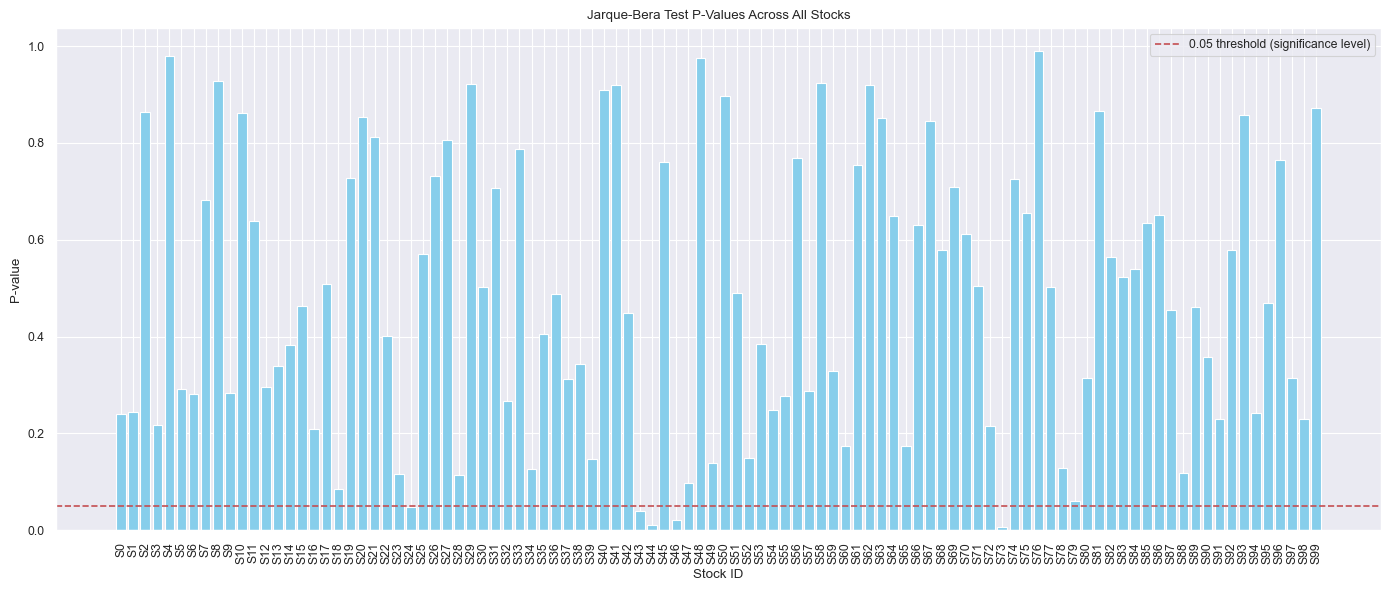

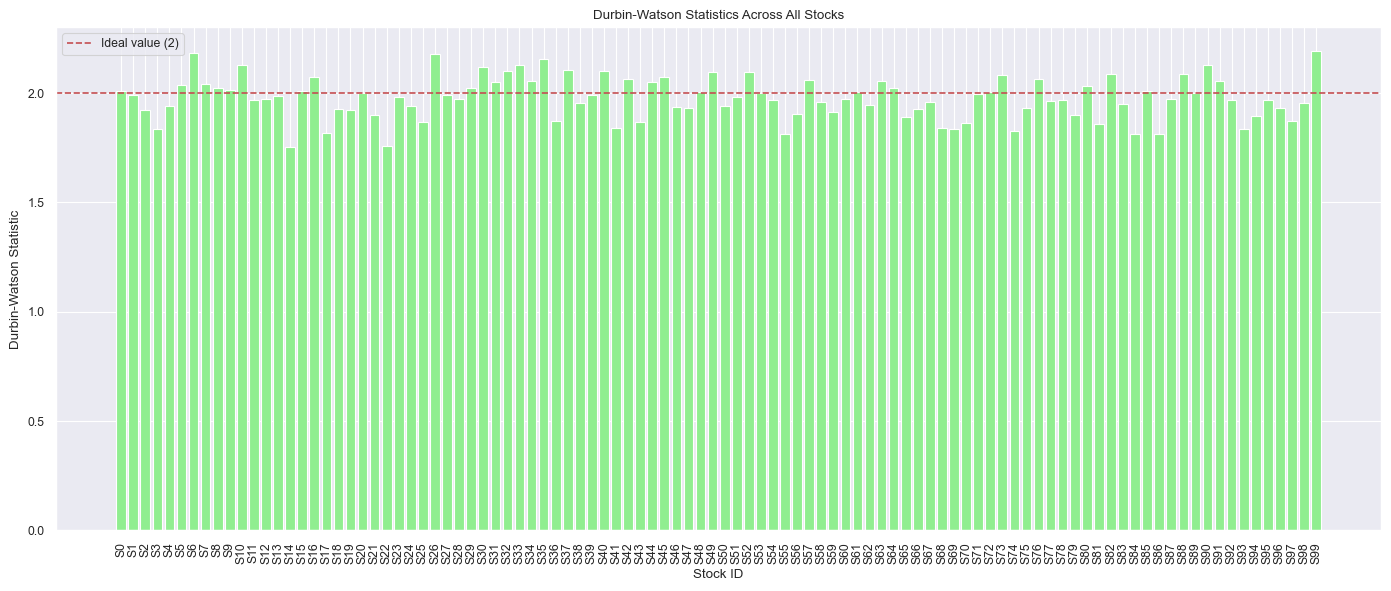

In [71]:
plot_jarque_bera_pvalues(results)
plot_durbin_watson_stats(results)

The Durbin-Watson (DW) statistic tests for autocorrelation in the residuals from regression. Specifically, it checks whether there is a pattern in the errors that may indicate time dependence. Based on the DW test, most of the stocks have DW values around 1.8 to 2.2, meaning little or no autocorrelation. However, a few stocks, such as S1 and S32, have slightly higher or lower values, suggesting mild autocorrelation (either positive or negative). The regression models for most of the stocks do not exhibit significant autocorrelation in the residuals.

The Jarque-Bera (JB) test is a goodness-of-fit test that checks whether the residuals follow a normal distribution. It tests for skewness and kurtosis.  The JB test indicates that for many stocks (where the p-values are above 0.05), the residuals appear to be normally distributed, which is good for the assumptions of the OLS regression. For the stocks with p-values below 0.05 (e.g., S0, S32, S55), the residuals are not normally distributed, which might indicate issues with model specification, such as missing variables or incorrect assumptions.


Next Step
> Further refinement (e.g., adding more features, using transformations, or trying different models) is needed

<a name="additional_features"></a>
### Feature Engineering <div id='additional_features'>

In [72]:
df = df_pivot_full.copy().drop(columns= ['C0_Spending', 'C1_Spending', 'C2_Spending',
       'C3_Spending', 'C4_Spending', 'C5_Spending', 'C6_Spending',
       'C7_Spending', 'C8_Spending', 'C9_Spending', 'Total_Spending'])
df

,date,stock,missing_spend,GICS sector,total_spend,active_cohorts
0,2015-01-01,S0,0,30,32.834279,4
1,2015-01-01,S1,0,35,37.403251,4
2,2015-01-01,S10,0,40,29.336547,3
3,2015-01-01,S11,0,30,32.373964,4
4,2015-01-01,S12,0,30,32.366248,4
...,...,...,...,...,...,...
292294,2023-01-01,S95,0,25,56.080810,6
292295,2023-01-01,S96,0,30,57.839224,6
292296,2023-01-01,S97,0,10,47.214733,6
292297,2023-01-01,S98,0,45,51.905760,6


In [73]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# 1. Add cohort-related features
# Average spend per cohort
df['avg_spend_per_cohort'] = df['total_spend'] / df['active_cohorts']

# Spend per active cohort change (using percentage change)
df['spend_per_cohort_change'] = df['avg_spend_per_cohort'].pct_change()

# Cohort spend growth (percentage change in total spend)
df['cohort_spend_growth'] = df['total_spend'].pct_change()

# Cohort spend momentum (rolling sum of cohort spend growth)
df['cohort_spend_momentum'] = df['cohort_spend_growth'].rolling(window=5).sum()

# Active cohort ratio (relative to maximum active cohorts in the data)
max_active_cohorts = df['active_cohorts'].max()
df['active_cohort_ratio'] = df['active_cohorts'] / max_active_cohorts

# 2. Add sector-based features
# Average spend per sector
sector_avg_spend = df.groupby(['date', 'GICS sector'])['total_spend'].mean().reset_index(name='sector_avg_spend')
df = pd.merge(df, sector_avg_spend, on=['date', 'GICS sector'], how='left')

# Sector spend relative to total spend
df['sector_spend_relative'] = df['total_spend'] / df['sector_avg_spend']

# Sector-wise spend momentum (rolling percentage change in total spend for a sector)
df['sector_spend_momentum'] = df.groupby('GICS sector')['total_spend'].pct_change().rolling(window=5).sum()

# 3. Add interaction features (total spend * active cohorts)
df['interaction_spend_active_cohorts'] = df['total_spend'] * df['active_cohorts']
df

,date,stock,missing_spend,GICS sector,total_spend,active_cohorts,avg_spend_per_cohort,spend_per_cohort_change,cohort_spend_growth,cohort_spend_momentum,active_cohort_ratio,sector_avg_spend,sector_spend_relative,sector_spend_momentum,interaction_spend_active_cohorts
0,2015-01-01,S0,0,30,32.834279,4,8.208570,NaN,NaN,NaN,0.4,32.500583,1.010267,NaN,131.337114
1,2015-01-01,S74,0,35,33.522869,4,8.380717,0.020972,0.020972,NaN,0.4,33.844901,0.990485,NaN,134.091476
2,2015-01-01,S73,0,30,29.924269,4,7.481067,-0.107348,-0.107348,NaN,0.4,32.500583,0.920730,NaN,119.697074
3,2015-01-01,S72,0,50,29.413566,4,7.353391,-0.017067,-0.017067,NaN,0.4,33.956840,0.866204,NaN,117.654263
4,2015-01-01,S71,0,25,37.094421,4,9.273605,0.261133,0.261133,NaN,0.4,32.580346,1.138552,NaN,148.377682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292294,2023-01-01,S33,0,30,53.170660,5,10.634132,0.223678,0.019732,0.024637,0.5,52.019691,1.022126,-0.194275,265.853298
292295,2023-01-01,S32,0,25,53.646556,6,8.941093,-0.159208,0.008950,-0.004920,0.6,52.901198,1.014090,-0.095307,321.879338
292296,2023-01-01,S31,0,40,53.210070,6,8.868345,-0.008136,-0.008136,0.010977,0.6,52.419733,1.015077,-0.157504,319.260418
292297,2023-01-01,S40,0,25,57.387472,6,9.564579,0.078508,0.078508,0.130507,0.6,52.901198,1.084805,-0.046749,344.324832


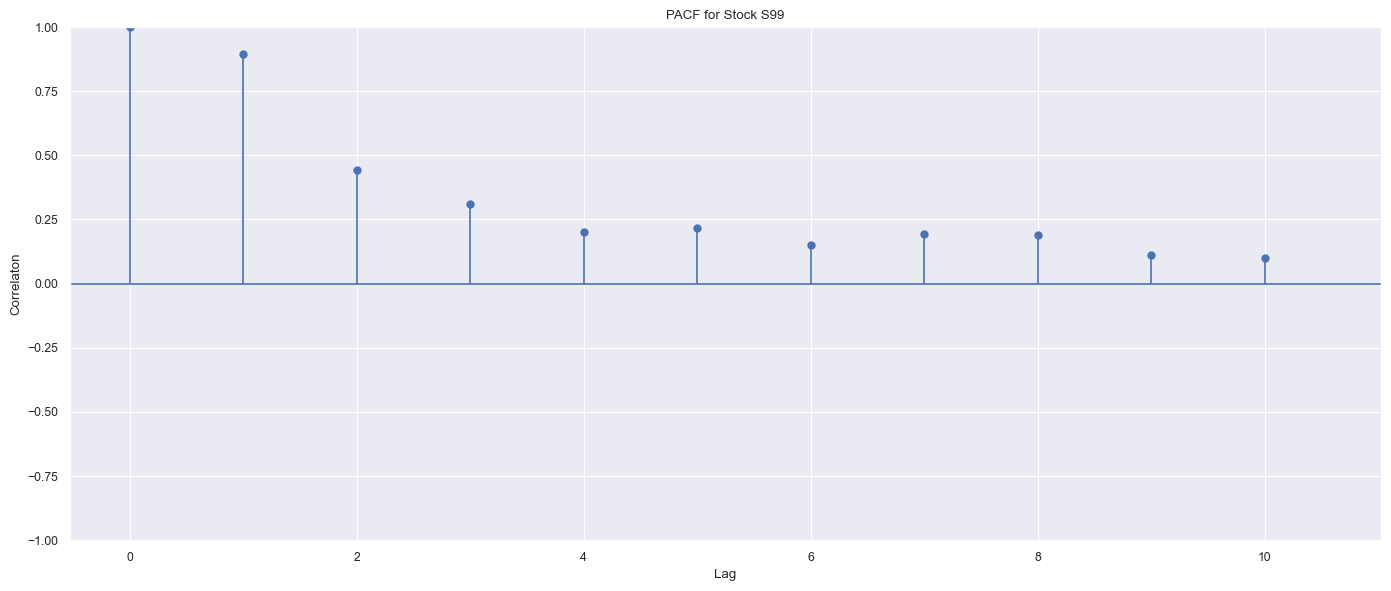

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# PACF plot (shows partial autocorrelation)
plot_pacf(df['total_spend'], lags=10, ax=ax)  # Adjust 'lags' as needed
ax.set_title(f'PACF for Stock {stock}')
ax.set_xlabel("Lag")
ax.set_ylabel("Correlaton")

plt.tight_layout()
plt.show()

There is clear significance up to lag 3, and the signal starts to diminish around lag 6, but if we want to capture more of the possible delayed effects, including lags up to 6 could be reasonable. Obviously, this is a pacf test for one stock and it would vary for other stocks but we can use this as a baseline

In [75]:
df = df.drop(columns = ['missing_spend','GICS sector', 'active_cohorts', 'spend_per_cohort_change','interaction_spend_active_cohorts'])

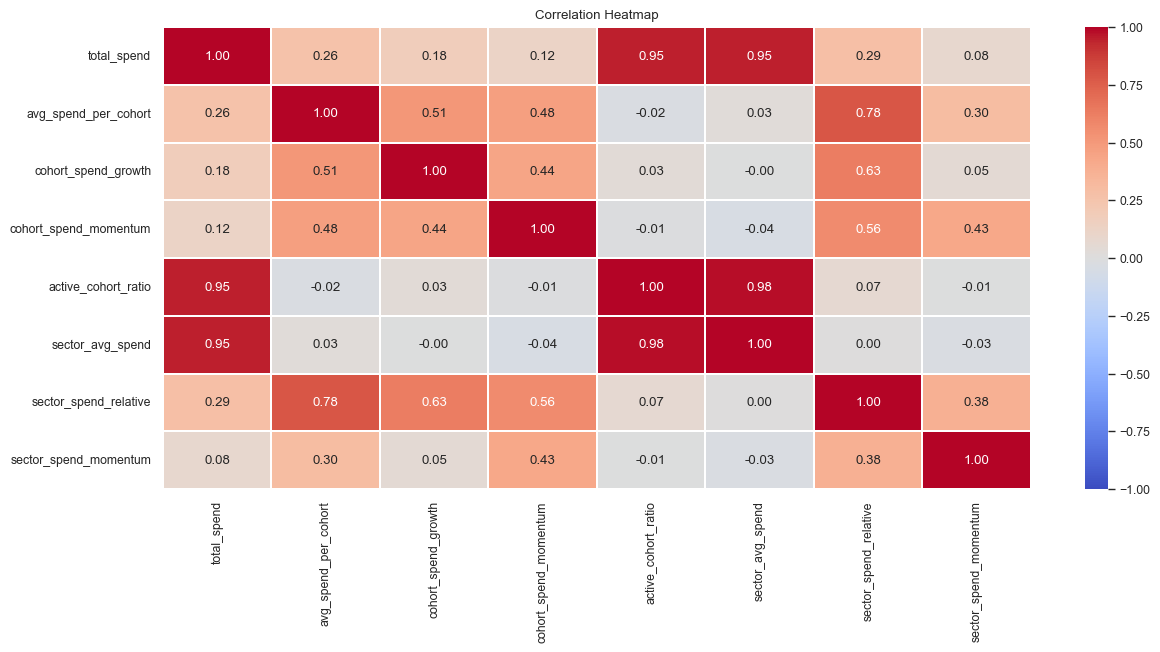

In [76]:
numerical_cols = ['total_spend', 'avg_spend_per_cohort',
       'cohort_spend_growth', 'cohort_spend_momentum', 'active_cohort_ratio',
       'sector_avg_spend', 'sector_spend_relative', 'sector_spend_momentum']
# Calculate the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot the heatmap using seaborn with a coolwarm colormap
plt.figure(figsize=(14, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.1, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [77]:
threshold = 0.8

# Create a mask to identify correlations that meet the threshold
corr_matrix = df[numerical_cols].corr().abs()  # Use absolute values to capture both positive and negative correlations
high_corr_pairs = np.where(corr_matrix < threshold)

# Filter the correlations and create a list of pairs
high_corr_list = []
for i in range(len(high_corr_pairs[0])):
    if high_corr_pairs[0][i] != high_corr_pairs[1][i]:  # Avoid self-correlations
        high_corr_list.append((corr_matrix.index[high_corr_pairs[0][i]], 
                               corr_matrix.columns[high_corr_pairs[1][i]], 
                               corr_matrix.iloc[high_corr_pairs[0][i], high_corr_pairs[1][i]]))

# Remove duplicates since correlations are symmetric
unique_high_corr_list = list(set([tuple(sorted(item[:2])) + (item[2],) for item in high_corr_list]))

high_corr_df = pd.DataFrame(unique_high_corr_list, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_df.sort_values(by='Correlation', ascending=False, inplace=True)

In [78]:
high_corr_df['Correlation'] = high_corr_df['Correlation'].round(2)
high_corr_df

,Feature 1,Feature 2,Correlation
10,avg_spend_per_cohort,sector_spend_relative,0.78
20,cohort_spend_growth,sector_spend_relative,0.63
16,cohort_spend_momentum,sector_spend_relative,0.56
15,avg_spend_per_cohort,cohort_spend_growth,0.51
3,avg_spend_per_cohort,cohort_spend_momentum,0.48
13,cohort_spend_growth,cohort_spend_momentum,0.44
7,cohort_spend_momentum,sector_spend_momentum,0.43
6,sector_spend_momentum,sector_spend_relative,0.38
22,avg_spend_per_cohort,sector_spend_momentum,0.30
11,sector_spend_relative,total_spend,0.29


High correlations between features indicate multicollinearity, which can lead to overfitting if both features are included. We want to avoid highly correlated features

In [79]:
df_filtered = df[['date', 'stock','total_spend', 'avg_spend_per_cohort', 'cohort_spend_growth', 'sector_spend_momentum', 'active_cohort_ratio']]
stock_dataframes = {}

# Loop through each unique stock in the 'stock' column
for stock_id in df_filtered['stock'].unique():
    # Create a DataFrame for each stock, excluding the 'stock' column
    stock_df = df_filtered[df_filtered['stock'] == stock_id].drop(columns='stock')
    
    # Set 'date' as the index
    stock_df = stock_df.set_index('date')
    
    # Create lagged versions of 'total_spend' by 2, 5, and 7 days
    stock_df['total_spend_lag_2'] = stock_df['total_spend'].shift(2)
    stock_df['total_spend_lag_5'] = stock_df['total_spend'].shift(5)
    stock_df['total_spend_lag_7'] = stock_df['total_spend'].shift(7)
    
    # Store the DataFrame in the dictionary with the stock ID as the key
    stock_dataframes[stock_id] = stock_df


# Example: Access the DataFrame for a specific stock
df_S0 = stock_dataframes['S0']  # DataFrame for stock 'S0'

# Show the first few rows of the DataFrame for 'S0'
df_S0

,total_spend,avg_spend_per_cohort,cohort_spend_growth,sector_spend_momentum,active_cohort_ratio,total_spend_lag_2,total_spend_lag_5,total_spend_lag_7
date,,,,,,,,
2015-01-01,32.834279,8.208570,NaN,NaN,0.4,NaN,NaN,NaN
2015-01-02,31.060791,7.765198,-0.145167,0.079980,0.4,NaN,NaN,NaN
2015-01-03,33.704683,8.426171,0.505195,-0.466631,0.4,32.834279,NaN,NaN
2015-01-04,33.949211,8.487303,-0.095515,0.026592,0.4,31.060791,NaN,NaN
2015-01-05,32.803826,8.200957,-0.109309,1.152142,0.4,33.704683,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-12-28,90.796984,9.079698,0.001915,0.102619,1.0,86.994870,84.335701,99.031001
2022-12-29,89.215429,8.921543,-0.015537,0.071910,1.0,84.225952,83.728594,89.689390
2022-12-30,84.759288,8.475929,-0.158830,0.045946,1.0,90.796984,92.850056,84.335701


In [80]:
results = train_models(stock_dataframes, df_pivot_returns)
results['S0']

{'Random Forest': {'model': RandomForestRegressor(max_depth=2, max_features='sqrt', n_estimators=10,
                        random_state=42),
  'RMSE': 0.007476028402966916,
  'R²': 0.002340663366682705,
  'MAE': 0.005858657780014987},
 'Lasso': {'model': Lasso(alpha=0.001),
  'RMSE': 0.007501141169095739,
  'R²': -0.004373079206636543,
  'MAE': 0.005859558237607283}}

<a name="feature_imp"></a>
### Visualizing Feature Importances <div id='feature_imp'>

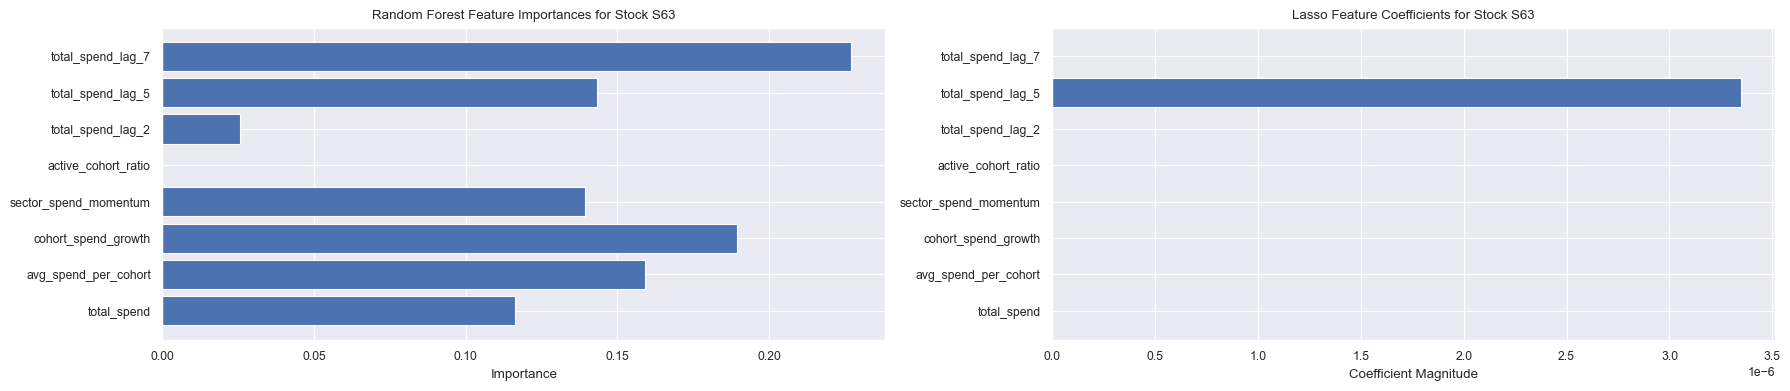

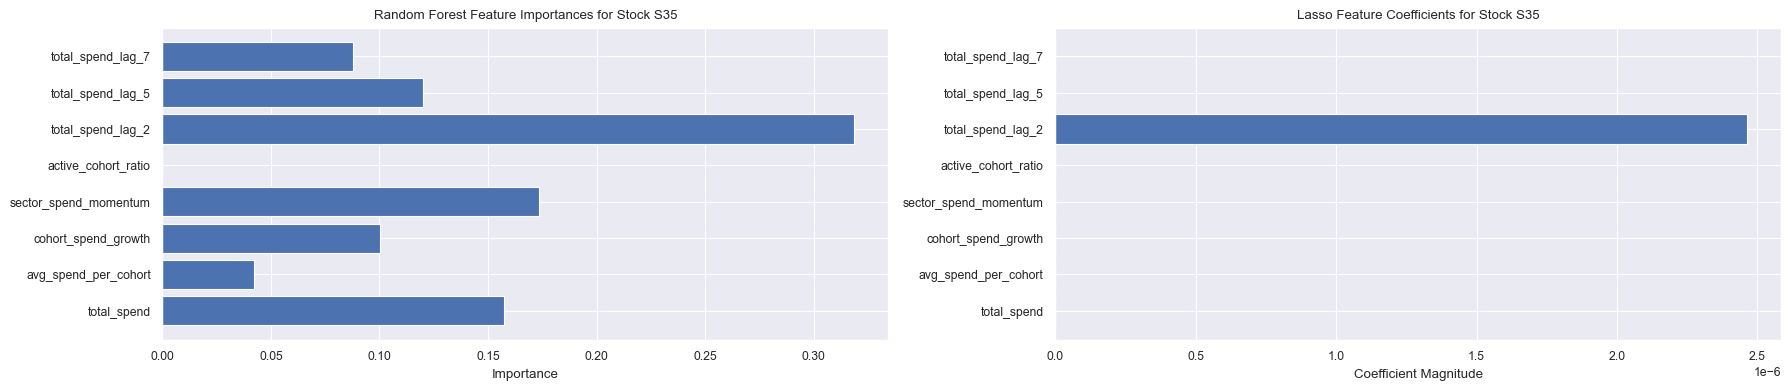

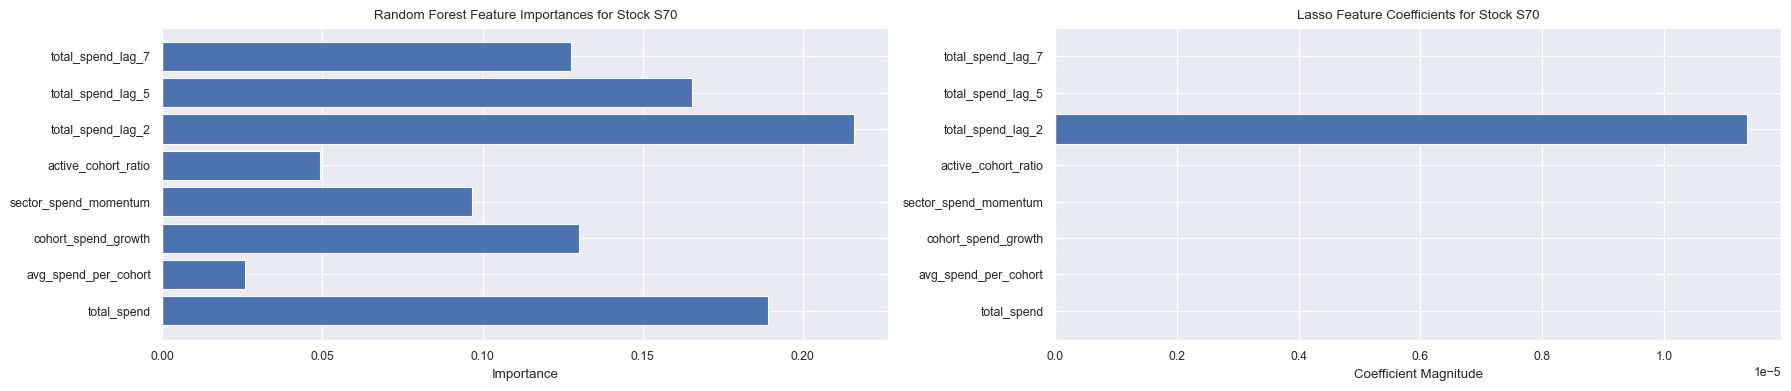

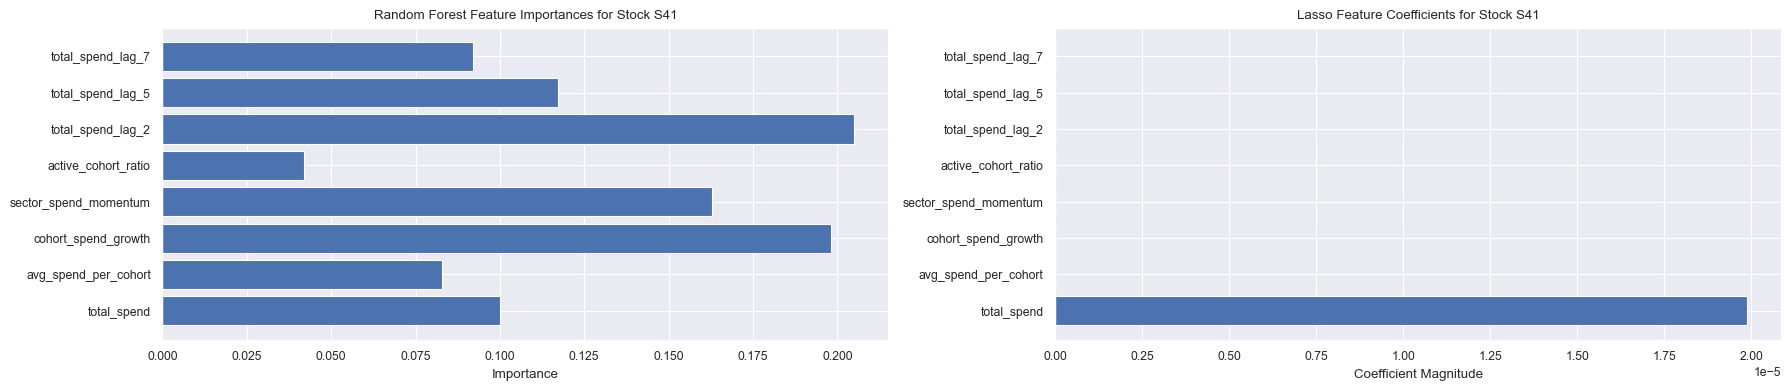

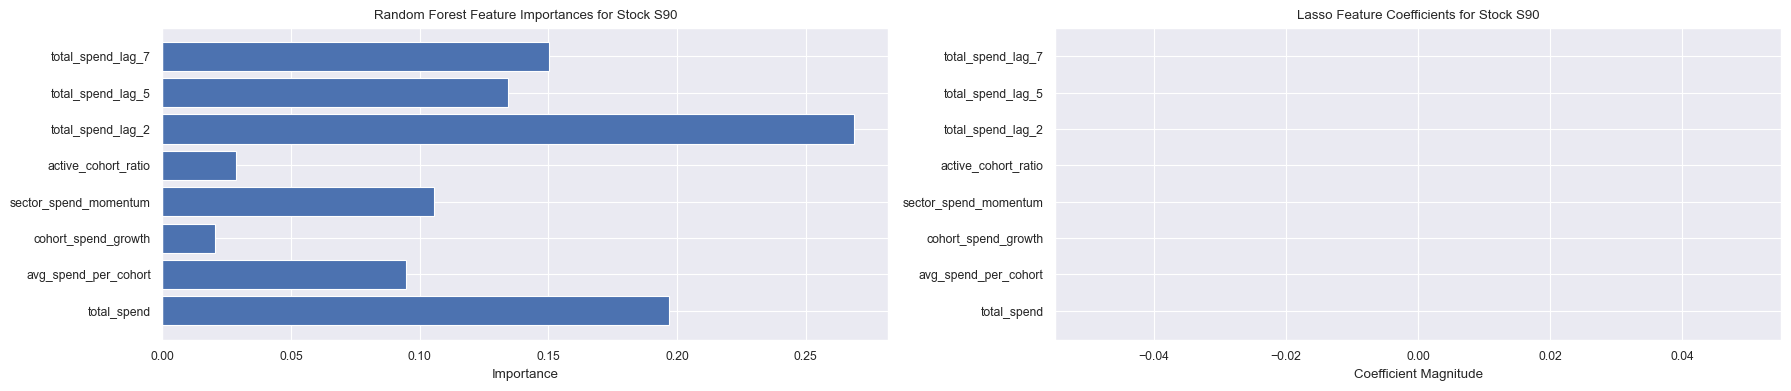

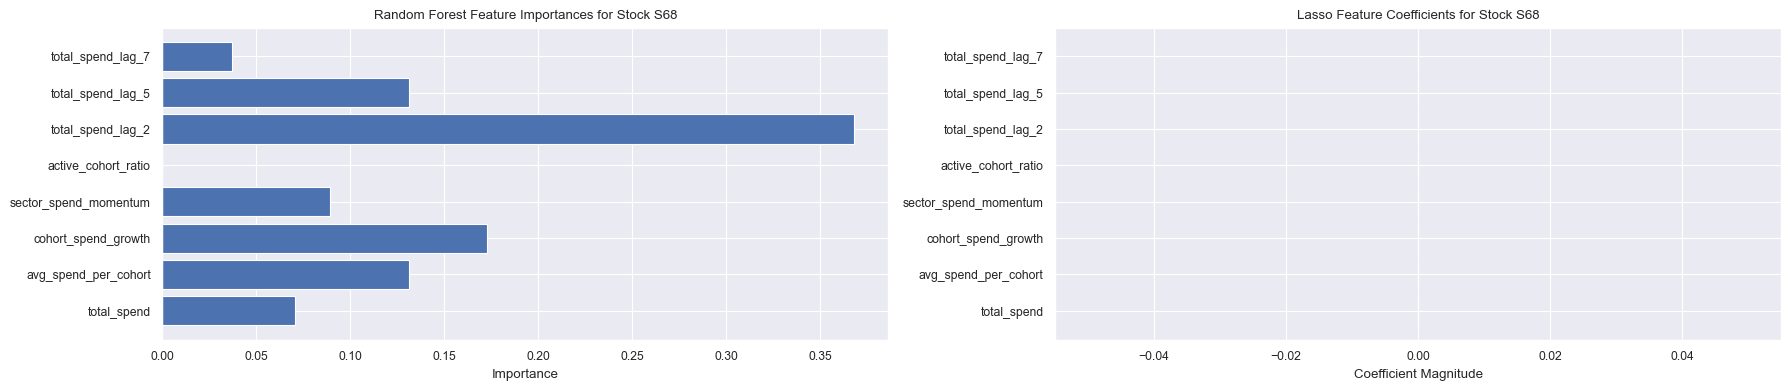

In [81]:
highest_spend_stocks = stock_total_spend.head(3).reset_index().stock.values
lowest_spend_stocks = stock_total_spend.tail(3).reset_index().stock.values

feature_cols = ['total_spend', 'avg_spend_per_cohort', 'cohort_spend_growth',
       'sector_spend_momentum', 'active_cohort_ratio', 'total_spend_lag_2',
       'total_spend_lag_5', 'total_spend_lag_7']

for stock_id in highest_spend_stocks:
    plot_feature_importances(results[stock_id]['Random Forest']['model'], results[stock_id]['Lasso']['model'], feature_cols, stock_id)

for stock_id in lowest_spend_stocks:
    plot_feature_importances(results[stock_id]['Random Forest']['model'], results[stock_id]['Lasso']['model'], feature_cols, stock_id)

Analysis:
* Total Spend is by far the most important predictor for this stock in both models, but especially in Lasso. total_spend_lag_2 also has high importance, indicating that spending from two days prior is quite relevant for predicting the target. total_spend_lag_5 also contributes meaningfully, but to a lesser extent than total_spend and total_spend_lag_2. 
* The Random Forest model considers other features like Cohort Spend Growth as meaningful contributors, but Lasso doesn’t consider them significant.

Next Step
> Retrain my models using these features

<a name="ht"></a>
### Final Modeling <div id='ht'>

In [82]:
selected_features = ['total_spend', 'cohort_spend_growth', 'avg_spend_per_cohort', 'total_spend_lag_2']
results = train_models(stock_dataframes, df_pivot_returns, features=selected_features)

results['S0']

{'Random Forest': {'model': RandomForestRegressor(max_depth=2, max_features='sqrt', n_estimators=10,
                        random_state=42),
  'RMSE': 0.007483329645750435,
  'R²': 0.00039104264138090095,
  'MAE': 0.005864442317359089},
 'Lasso': {'model': Lasso(alpha=0.001),
  'RMSE': 0.007486303651098012,
  'R²': -0.00040363920615504867,
  'MAE': 0.005857451202120871}}

I chose to plot the importances for highest spend stocks and lowest spend stocks

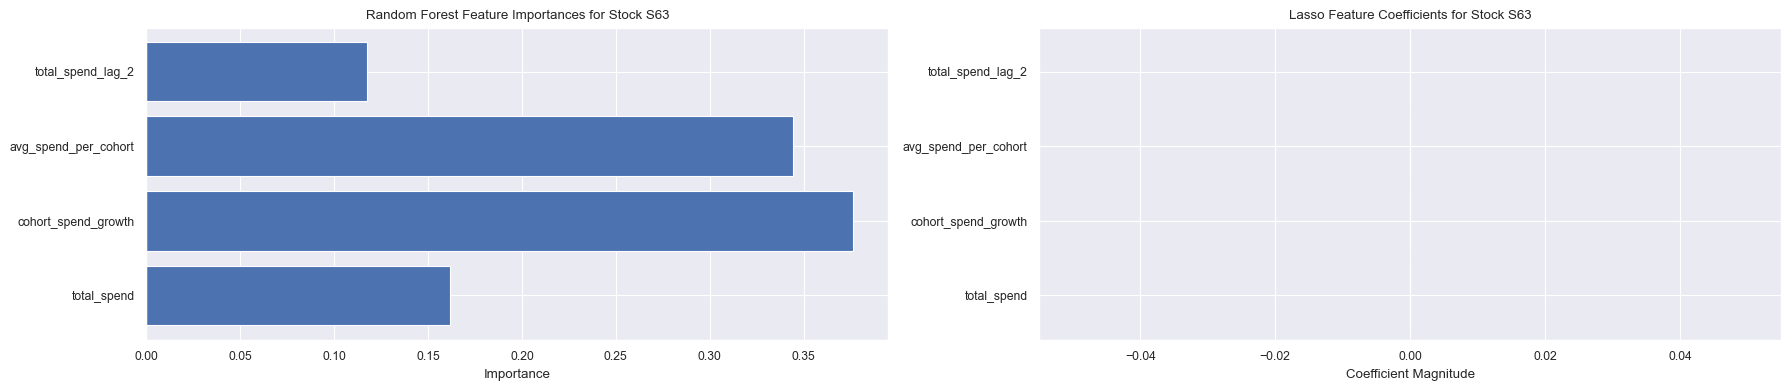

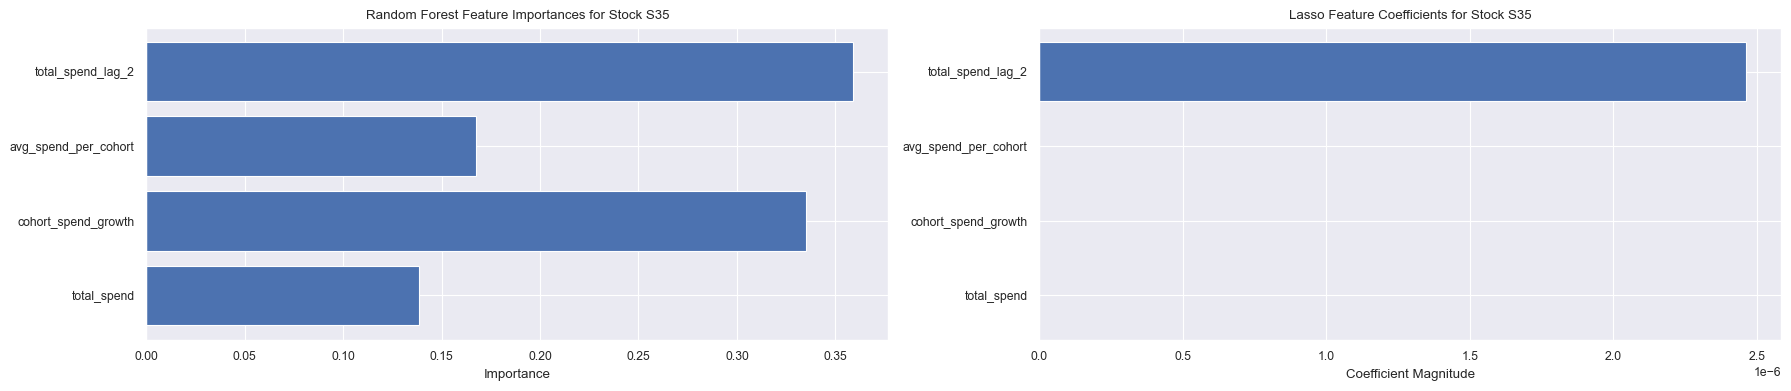

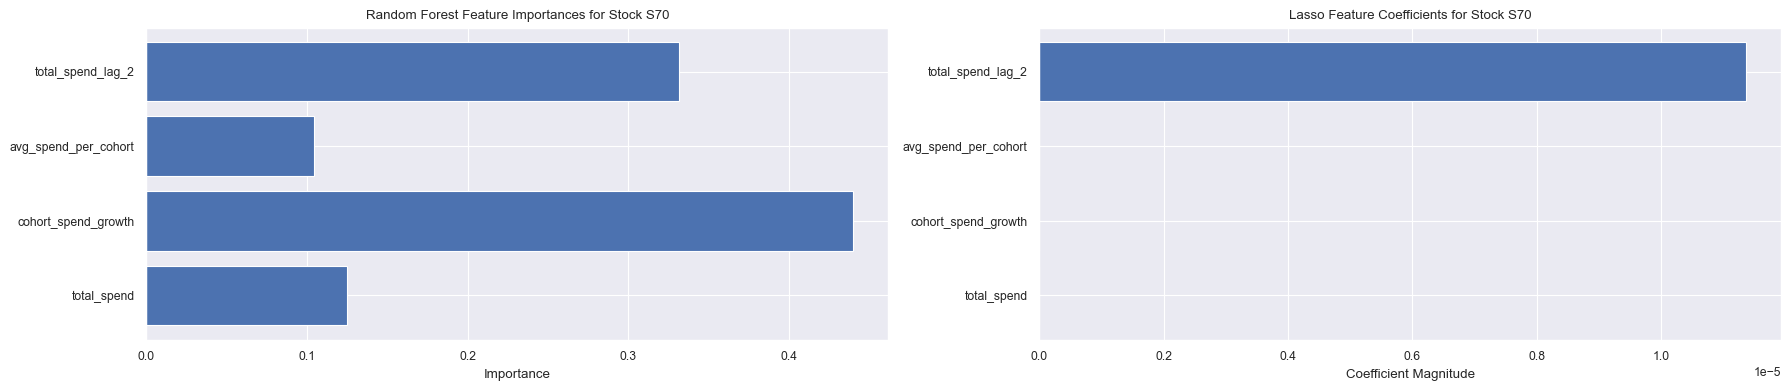

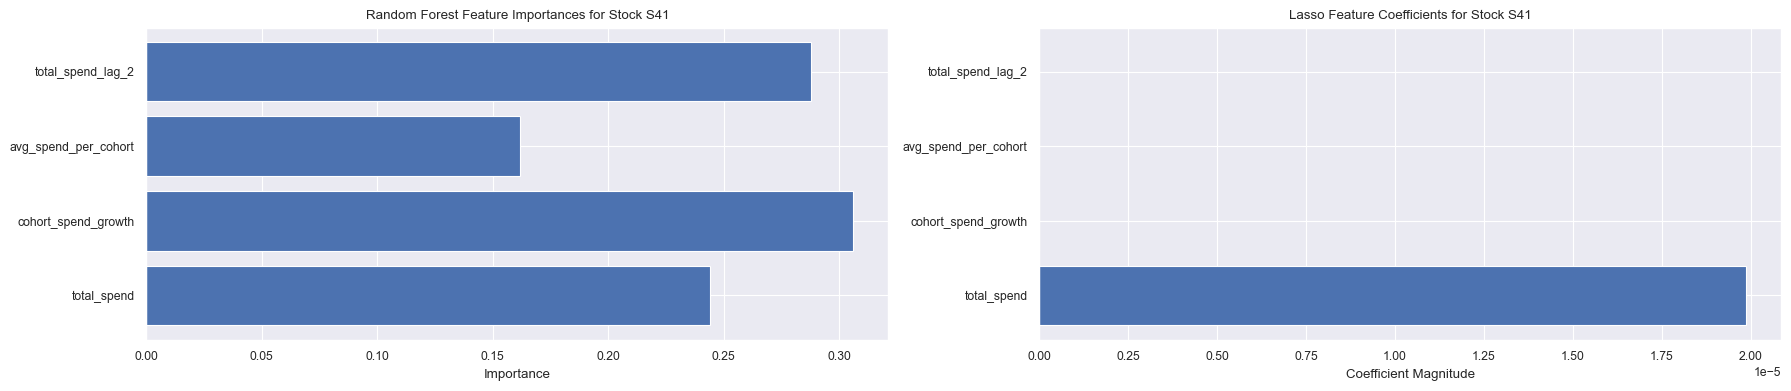

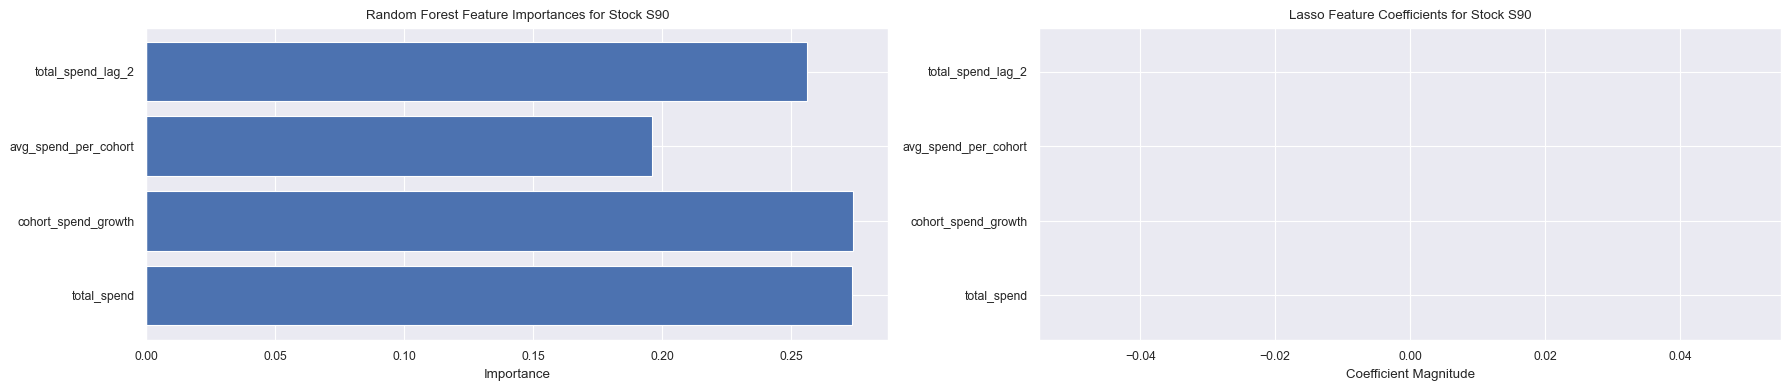

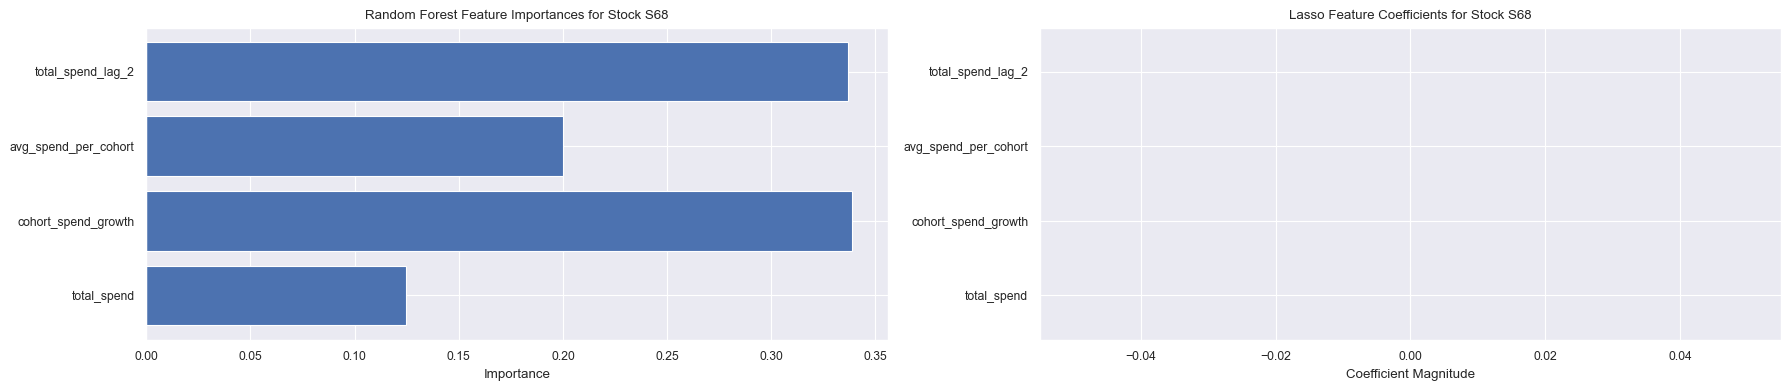

In [83]:
highest_spend_stocks = stock_total_spend.head(3).reset_index().stock.values
lowest_spend_stocks = stock_total_spend.tail(3).reset_index().stock.values

for stock_id in highest_spend_stocks:
    plot_feature_importances(results[stock_id]['Random Forest']['model'], results[stock_id]['Lasso']['model'], selected_features, stock_id)

for stock_id in lowest_spend_stocks:
    plot_feature_importances(results[stock_id]['Random Forest']['model'], results[stock_id]['Lasso']['model'], selected_features, stock_id)

* Lagged spend features (e.g., total_spend_lag_2) have a prominent influence on predicting stock returns. After retraining with the most important features, the importance of total_spend_lag_2 increases significantly, indicating that recent spend with a 2 day lag plays a critical role in explaining stock returns. Lags of 5 and 7 days are somewhat less important but still contribute to the model. The fact that they are included as important after selection suggests a multi-day lag effect on stock performance, though weaker than total_spend_lag_2

* Features like sector_spend_momentum and cohort_spend_growth also appear important in the original model. After feature selection, these features retain relevance but slightly decrease in importance.
These features may explain broader economic trends (e.g., sectoral performance or cohort-based behaviors), but they are less critical than immediate spend data. The lower importance in both iterations may indicate that cohort activity ratios do not strongly drive immediate stock performance but could still offer a background context. 

* The sparsity induced by Lasso is apparent, as many features have very small or zero coefficients, meaning they are deemed less relevant by this model's regularization.
* The fact that both models (Random Forest and Lasso) emphasize similar features (with different weights) increases confidence in the importance of these predictors, particularly total spend and lagged spend.

> The analysis indicates that immediate and lagged total spend metrics are key predictors of stock returns, and card spending data offers valuable insights into short-term stock movements. Additionally, features like cohort spend momentum and sector momentum still provide complementary information but don't have high relative importance like the former predictors

<a name="sector_analysis"></a>
## Sector Performance Analysis <div id='sector_analysis'>

<a name="model_sector_eval"></a>
### Evaluate Model by Sector <div id='model_sector_eval'>

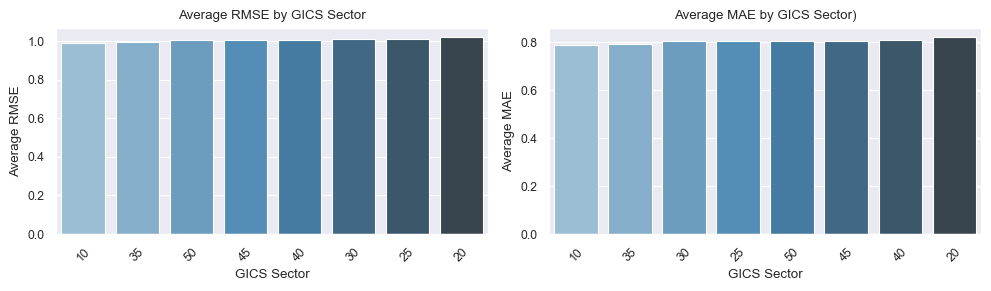

In [84]:
plot_sector_metrics(sector_results)

* RMSE gives more weight to large errors because it squares the differences before averaging. This means that higher RMSE values may indicate that the model is particularly poor at predicting large deviations in certain sectors
* MAE, unlike RMSE, is a linear score, so it does not penalize large errors as heavily -  tt simply averages the absolute errors. A higher MAE indicates generally worse predictions, but not as much sensitivity to outliers as RMSE.
    * The RMSE and MAE are fairly consistent across sectors, indicating the model performs similarly across these sectors - Sector 10 is the top performing sector and the worst sector is 20 as identified by the models. Overall, the errors seem to be in a narrow range, which suggests that the model performs uniformly across sectors with negligble difference between sectors

<a name="inclusion_exclusion"></a>
### Interpretation and Sector Inclusion Decision <div id='inclusion_exclusion'>

Regarding the inclusion-exclusion of worst performing sectors, it’s important to weigh the pros and cons.
Removing poorly performing sectors can make the model less generalizable, especially if future data includes
those sectors. Additionally, removing sectors may reduce diversification and increase the risk of sector-
specific idiosyncrasies dominating the portfolio of stocks. However, removing the worst-performing sectors
can simplify the analysis and reduce error metrics. Given additional time, I would first analyze why some
sectors perform worse and explore ways to improve the model for those sectors before considering discarding
them from the model. I would hypothesize that the well-performing sectors are probably sectors heavily
dependent on consumer spending such retail and worse-performing sectors are those that are not directly
dependent on consumer spending

<a name="trading_strategy"></a>
## Trading Strategy <div id='trading_strategy'>

<a name="signal_generation"></a>
### Signal Generation Methods <div id='signal_generation'>

- Mean Reversion Strategy

Based on my analysis above, returns data reverts back to its mean and stay around $\mu$=0.Hence,  I will employ a Mean Reversion Strategy which assumes that stocks tend to revert to their historical mean performance after deviating significantly. Since we are working with 100 stocks and seasonally adjusted total spend data - here's how I will implement:

1. For each stock, I compute a moving average (e.g., 30-day or 60-day average) of my predictor (total spend, corrected for seasonality) and compare the current value to the moving average.
    - Buy signal: If the predictor is below the moving average and we expect a mean reversion (predicting future returns to rise).
    - Sell signal: If the predictor is significantly above the moving average (predicting a correction or drop in returns).

I can apply this across all stocks and hold only those with strong signals or maintain a fully invested portfolio that periodically adjusts based on these signals.

<a name="zscore_resid"></a>
#### Signal Generation using Z-Score <div id='zscore_resid'>

1. Using the seasonally adjusted spend data at times $t−1$ and $t$ as the input, I generated signals based on deviations from a rolling mean of the spend data.
2. Using those signals, I predicted the future return  $r(t,t+1)$

In [682]:
z_scores = calculate_z_scores(time_series_df)
signals = identify_overbought_oversold(z_scores)

print(signals.tail())

<a name="cum_pnl"></a>
### Cumulative PnL <div id='cum_pnl'>

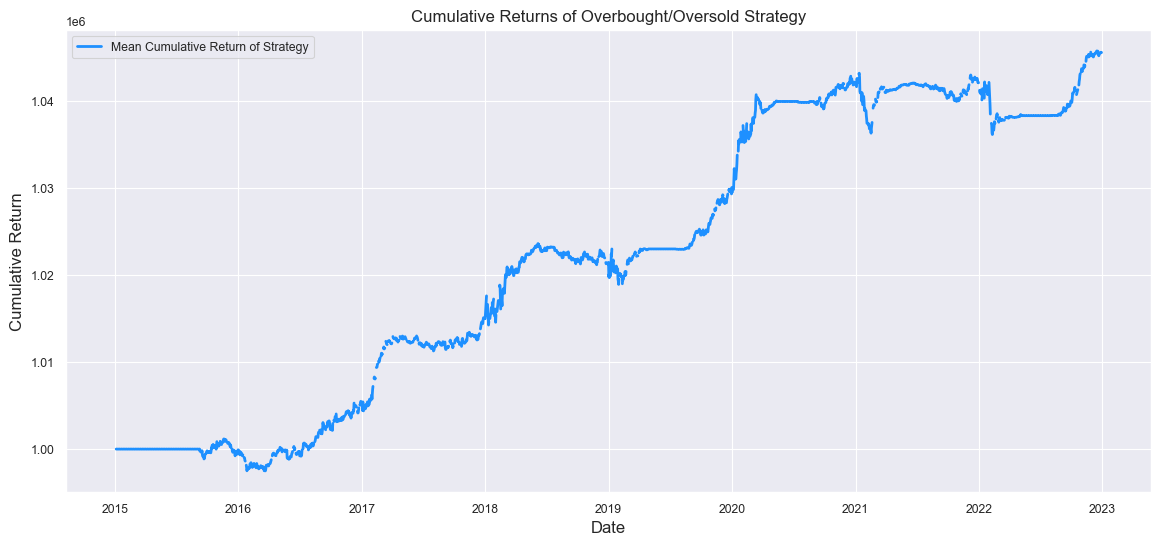

In [111]:
cumulative_returns = backtest_strategy(signals, df_pivot_returns)


plt.figure(figsize=(14, 6))
plt.plot(cumulative_returns.mean(axis=1), label='Mean Cumulative Return of Strategy', color='dodgerblue', linewidth=2)
plt.title('Cumulative Returns of Overbought/Oversold Strategy', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Some observations:
* The mean cumulative return shows an upward trend, indicating that the strategy has been able to capture positive returns over the long term.
* We can observe noticeable flat periods (e.g., between 2015-2016, 2020-2021), where the strategy might not be generating signals or the signals are neutral, leading to limited changes in the portfolio.
* However, In some areas, like early 2020 (likely the COVID crash), 2021 and early 2022 (Russian invasion of Ukraine), the strategy experiences sharp drawdowns. This could indicate that overbought/oversold conditions might not work well during sharp market downturns

In [98]:
performance_metrics = calculate_performance_metrics(cumulative_returns.mean(axis=1))

metrics_df = pd.DataFrame([performance_metrics])
metrics_df

,Sharpe Ratio,Max Drawdown,Hit Ratio,Annualized Volatility
0,1.039807,-0.006748,0.289284,0.0037


* The Sharpe ratio indicates the strategy is generating returns that are fairly consistent relative to the risk taken
* The max drawdown is very low which could indicate that the strategy is not taking much risk or the period of drawdown is very small.
* Strategy was only correct about 29% of the time, meaning there were many loser trades.
* Annualized volatility is also low which points to either the strategy not taking much risk or returns are stable

<a name="additional_data"></a>
## Additional Data Sources <div id='additional_data'>

1. **Financial Metrics**<br>
    Financial statements reported by companies can serve as one of the potential data sources to enhance our forecasting of daily returns. Typical financial statements consist of **balance sheet, income statements and cash flow statements**. From such statements, we can observe the current status of companies' assets and liabilities, as well as their ability to generate profits and cash flow based on their resources. Using numbers from financial statements, one can construct various metrics that can represent the overall financial health of the companies which could be indicative of the companies' future returns.

    The three types of metrics we would be interested at:
    1. The metrics that are absolute levels, such as revenue, expenses, or operating incomes etc.
    2. The metrics that are in the form of growth rate, such as revenue growth, eps growth etc.
    3. The metrics that are in the form of ratios, such as price/book value, earnings/price of the security etc.

    When comparing companies for investment, financial analysts typically rely on growth rates and ratios but not absolute level metrics.  Therefore, the last two categories of metrics are good measures of future returns but the first category requires more feature engineering . The reason is there will be inherent size or sector bias in level metrics that will impact our model performance without further scaling. **Specifically, companies with larger size will always have a higher revenue number compared to small cap companies. However, the size of the company itself is not necessarily indicative of the stock's future return level.** For example, price to earnings ratio is one of the most well-known valuation metrics for a stock but there is no practitioner that uses the level of the price of the level of the earnings of a company itself to determine future stock returns. Another real life example would be people will not choose their purchase by saying product A costs 500 dollars but product B costs 10 dollars so one will choose product B without any knowledge of what product A/B is. The decision would be completely reversed if one is paying 500 dollars for a house or 10 dollars for a pencil.

2. **Consumer Sentiment** <br>
Additiona data source could be customer ratings which could contain information asymmetry that can be exploited for alpha generation. Customer ratings capture soft information about consumer behavior that is predictive of stock performance, especially for companies heavily reliant on consumer sales and attention (e.g., retail, tech, consumer goods).

3. **Confumer Confidence** 

    Credit card spending data itself can also be used to infer consumer confidence, especially by focusing on discretionary spending patterns. Discretionary spending refers to purchases that consumers make for non-essential items, which often reflects their confidence in the economy and their personal financial situation. If consumers are spending more on luxury or non-essential goods, it can indicate higher confidence, whereas a reduction in discretionary spending may signal economic uncertainty.

    By comparing credit card spending patterns with broader economic indicators like the Personal Consumption Expenditure (PCE) index, we can derive a useful proxy for consumer confidence. PCE data is typically reported monthly, while credit card data is often available on a more granular (e.g., weekly) basis. By harmonizing the time frequencies of these two datasets—using both month-over-month (MoM) and year-over-year (YoY) changes—we can analyze the correlation between credit card spending and PCE. If a strong correlation is found, it would suggest that changes in credit card spending are predictive of broader consumer confidence levels.

    By extracting discretionary spending trends from credit card data and aligning it with PCE, we can estimate consumer confidence, which could provide predictive value in forecasting stock returns. This additional layer of data could further enhance the model's ability to forecast market movements based on consumer behavior patterns.

<a name="conclusion"></a>
## Future Work <div id='conclusion'>

Interesting relationships I would explore further
> For forecasting returns, knowing which cohorts' spending are correlated can help us understand which cohorts are moving in tandem and likely amplifying changes in stock returns <br>
> We can look at Cohort Influence on Specific Sectors <br>
> We can look at monthly and quarterly seasonalities by performing a seasonal decomposition <br>
> We can consider giving more weight to transactions from the highly active cohorts and sectors. 



I would try the following approaches in the future:

* Momentum is most effective for short- to medium-term forecasting, where assets that have performed well or poorly continue to do so over the near future. We can exploit momentum based on past returns adjusted by T-Statistics. The t-statistics help filter out signals that are statistically significant and focus on strong trends instead. These momentum signals can be useful in trading individual stocks similar to our problem.

* Reframe our forecasting problem into a multi-classification problem. We would assume we have a portfolio with a position in $n$ stocks. We are going to attempt to forecast directional changes in the portfolio returns — specifically, we make a decision on whether to long or short the entire portfolio based on our prediction of the next-day portfolio return. The data I would use would be the same daily returns data, and I would calculate the portfolio returns using equal weighting. This diversifies away the noise and idiosyncracies associated with each individual stock - rather forecasting each individual stock, we diversify the risk in our portfolio
    * Given we have cross-sectional market data, we want to predict the next-day portfolio returns.
    
    * I would first start out by defining my stock returns as:
    
    $$
    r_p(t) = \sum_{i=1}^{n} w_{i,t} \cdot r_i(t) \quad \text{where} \quad w_{i,t} = \frac{1}{n}
    $$
      
    * The observed data would consist of the historical return of all the stocks, and then we label the data with a categorical variable:
    <br>
      $$
      Y_t = 
      \begin{cases} 
      1 & \text{if } r_p(t+1) > \epsilon \\
      0 & \text{if } |r_p(t+1)| \leq \epsilon \\
      -1 & \text{if } r_p(t+1) < -\epsilon
      \end{cases}
      $$

    * The goal would be to learn the map 
    $$
    Y_t = F_{W,b}(X_t) \cdot \epsilon
    $$
    * I would design a simple strategy $S(Y_t)$ which chooses whether to hold a long, neutral, or short position in all the stocks over the next period.


**This concludes my analysis. Thank you!**

<hr style="height:2pt">